# Analysis of extractive structures results

### Imports

In [20]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from typing import Any
from termcolor import colored
repo_root = get_root_of_git_repo()



import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from dataclasses import dataclass
from datasets import DatasetDict
from shared_ml.logging import LogState, load_log_from_wandb, paths_or_wandb_to_logs
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import numpy.typing as npt

import numpy as np
import matplotlib.pyplot as plt
if repo_root not in sys.path:\
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from shared_ml.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
import numpy as np
from kronfluence.score import load_pairwise_scores
from oocr_influence.cli.run_influence import InfluenceArgs

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


## Influence analysis

In [16]:
from collections import defaultdict
from typing import Any, Literal
import line_profiler
import time
import numpy as np
from numpy.typing import NDArray
import torch
from datetime import datetime
from datasets import Dataset
from pathlib import Path
import hashlib
from functools import cache
from typing import Generator
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
from shared_ml.utils import cache_function_outputs
import re
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import seaborn as sns
from termcolor import colored
import pandas as pd
from itertools import chain
import math

import hashlib
from collections import defaultdict
from typing import Any, List, Tuple

import numpy as np
from datasets import Dataset
from numpy.typing import NDArray
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
import safetensors
import hashlib, numpy as np
from collections import defaultdict
from typing import Any, List, Tuple
from datasets import Dataset
from numpy.typing import NDArray
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
import json
from oocr_influence.cli.train_extractive import TrainingArgs
import time
import wandb
from pydantic import BaseModel
from shared_ml.logging import LogState, load_log_from_disk
import cProfile
import pstats
import io
from pathlib import Path
import line_profiler 
import matplotlib.style as mplstyle



import hashlib, numpy as np, itertools
from collections import defaultdict
from typing import Any, List, Tuple
from datasets import Dataset, Features, Value, Sequence
from numpy.typing import NDArray
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast 



@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id = lambda x: hashlib.sha256(x["input_array"].tobytes()).hexdigest()[:8]) # type: ignore
def rank_influence_scores(input_array: np.ndarray[Any, Any] | torch.Tensor) -> np.ndarray[Any, Any]:
    if isinstance(input_array, torch.Tensor):
        input_array = input_array.cpu().numpy()
    return np.argsort(np.argsort(-input_array, axis=1), axis=1)

def get_parent_influence_scores(influence_scores: np.ndarray[Any,np.dtype[Any]] | torch.Tensor, test_dataset: Dataset) -> np.ndarray[Any,np.dtype[Any]]:
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.cpu().numpy()
    parent_idxs: list[int] = test_dataset["parent_fact_idx"]
    influence_scores_by_parent = influence_scores[np.arange(len(influence_scores)), parent_idxs]
    return influence_scores_by_parent


def cache_get_parent_influence_ranks(args: dict[str,Any]) -> str:
    train_dataset_fingerprint = args["train_dataset"]._fingerprint
    test_dataset_fingerprint = args["test_dataset"]._fingerprint
    influence_scores_hash = hashlib.sha256(args["influence_scores"].tobytes()).hexdigest()[:8]
    non_parents_instead_of_parents = str(args["non_parents_instead_of_parents"])
    return hash_str(f"{train_dataset_fingerprint}-{test_dataset_fingerprint}-{influence_scores_hash}-{non_parents_instead_of_parents}")

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id = cache_get_parent_influence_ranks)
def get_parent_influence_ranks(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, non_parents_instead_of_parents : bool = True) -> dict[int,NDArray[Any]]:
    
    influence_scores_rank = rank_influence_scores(influence_scores)

    types = train_dataset["type"]
    idxs = train_dataset["idx"]
    train_set_parent_idxs = [idx if "fact" in t else None for t,idx in zip(types,idxs)]
    
    parent_idxs_to_train_set_idxs = defaultdict(list)

    for train_set_idx, train_set_parent_idx in enumerate(train_set_parent_idxs):
        if train_set_parent_idx is not None:
            parent_idxs_to_train_set_idxs[train_set_parent_idx].append(train_set_idx)
        
    if non_parents_instead_of_parents:
        # Make it so that you are in the list if you are NOT a parent
        fact_indices = set(idx for idx, type in enumerate(train_dataset["type"]) if "fact" in type)
        parent_idxs_to_train_set_idxs = {k: list(fact_indices - set(v)) for k, v in parent_idxs_to_train_set_idxs.items()}
    parent_idxs_to_influence_ranks = {parent_idx: influence_scores_rank[parent_idx,train_set_idxs] for parent_idx,train_set_idxs in parent_idxs_to_train_set_idxs.items()}

    return parent_idxs_to_influence_ranks  

def plot_histogram_train_subset(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, subset_inds: list[int], title: str, xlabel: str, ylabel: str,bin_width: int = 10,max_value: int | None = None, fig: Figure | None = None, ax: Axes | None = None, test_inds_to_focus_on: list[int] | None = None, analysis_dir: Path | None = None):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()

    influence_ranks = rank_influence_scores(influence_scores)
    max_value = max_value or np.max(influence_ranks)
    subset_influence_ranks = influence_ranks[:,subset_inds]
    if test_inds_to_focus_on is not None:
        subset_influence_ranks = subset_influence_ranks[test_inds_to_focus_on]
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    ax.hist(subset_influence_ranks.flatten(), edgecolor="black", bins=np.arange(0, max_value + 1, bin_width)) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # show the figure
    fig.show()
    if analysis_dir is not None:
        save_location = analysis_dir / f"{title}_{plot_histogram_train_subset.__name__}.pdf".replace("\n", "_")
        fig.savefig(save_location, format="pdf")
    return fig, ax

def plot_histogram_parent_ranks(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, max_value: int | None = None, bin_width: int = 10,non_parents_instead_of_parents: bool = 
                                False,test_inds_to_focus_on: list[int] | None = None, analysis_dir: Path | None = None):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()
    parent_influence_ranks = get_parent_influence_ranks(influence_scores, train_dataset, test_dataset,non_parents_instead_of_parents)
    if test_inds_to_focus_on is not None:
        parent_influence_ranks = {k: v for k, v in parent_influence_ranks.items() if k in test_inds_to_focus_on}
    parent_influence_ranks = np.array(list(chain(*parent_influence_ranks.values())))
    fig, ax = plt.subplots()    
    max_value = max_value or np.max(parent_influence_ranks)
    ax.hist(parent_influence_ranks.flatten(), edgecolor="black", bins=np.arange(0, max_value + 1, bin_width))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()
    if analysis_dir is not None:
        save_location = analysis_dir / f"{title}_{plot_histogram_parent_ranks.__name__}.pdf".replace("\n", "_")
        fig.savefig(save_location, format="pdf")

def plot_histogram_parent_ranks_seaborn(
    influence_scores: NDArray[Any] | torch.Tensor,
    train_dataset: Dataset,
    test_dataset: Dataset,
    title: str,
    xlabel: str,
    ylabel: str,
    max_value: int | None = None,
    bin_width: int = 10,
    non_parents_instead_of_parents: bool = False
):
    """
    Plots overlaid histograms for parent influence ranks using Seaborn.

    Each row in the calculated parent_influence_ranks array gets its own
    histogram overlaid on the same plot.

    Args:
        influence_scores: A 2D array or tensor of influence scores (e.g., test_instances x train_instances).
        train_dataset: The training dataset object.
        test_dataset: The test dataset object.
        title: The title for the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis.
        max_value: The maximum value for the x-axis and bin calculation. If None, determined from data.
        bin_width: The width of each histogram bin.
        non_parents_instead_of_parents: Flag passed to get_parent_influence_ranks.
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores_np = influence_scores.to(dtype=torch.float32).cpu().numpy()
    else:
        influence_scores_np = np.asarray(influence_scores) # Ensure it's a numpy array

    # Get the 2D array of ranks (DO NOT FLATTEN here)
    parent_influence_ranks_2d = get_parent_influence_ranks(
        influence_scores_np, train_dataset, test_dataset, non_parents_instead_of_parents
    )

    if parent_influence_ranks_2d.size == 0: # type: ignore
        print("Warning: parent_influence_ranks_2d is empty. Cannot plot histogram.")
        return

    # --- Convert data to long-form DataFrame for Seaborn ---
    data_for_df = []
    for i, ranks_for_row in enumerate(parent_influence_ranks_2d):
        for rank in ranks_for_row:
            data_for_df.append({'rank': rank, 'row_index': i})
            
    if not data_for_df:
         print("Warning: No data found after processing ranks. Cannot plot histogram.")
         return
         
    df = pd.DataFrame(data_for_df)
    # Ensure row_index is treated as a category for distinct colors
    df['row_index'] = df['row_index'].astype('category') 
    # --- ---

    # Determine the maximum value for bins if not provided
    actual_max_rank = df['rank'].max()
    plot_max_value = max_value if max_value is not None else actual_max_rank
    
    # Define bins carefully to include the max value
    bins = np.arange(0, plot_max_value + bin_width, bin_width)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figsize as needed

    # Use seaborn histplot
    sns.histplot(
        data=df,
        x='rank',
        hue='row_index', # Color histograms by original row index
        bins=bins,
        binwidth=bin_width if bins is None else None, # Use either bins or binwidth
        element="step",  # Use 'step' for better visibility of overlays
        # kde=True,       # Uncomment to add Kernel Density Estimate plots
        ax=ax,
        palette='viridis', # Choose a color palette (optional)
        legend=True        # Show legend
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) # Seaborn might label this 'Count', override if needed

    # Optional: Set x-axis limit if max_value was specified
    if max_value is not None:
        ax.set_xlim(0, max_value)
    else:
        # Ensure the last bin edge is slightly beyond the max rank if automatically determined
         ax.set_xlim(0, plot_max_value + bin_width) 


    # Improve legend if there are many rows
    if len(df['row_index'].unique()) > 10:
         ax.legend(title='Row Index', bbox_to_anchor=(1.05, 1), loc='upper left')
         plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    else:
         ax.legend(title='Row Index')
         plt.tight_layout()


    # Use plt.show() for standard execution environments 
    # or fig.show() potentially in specific interactive environments
    fig.show()
    return fig, ax

def get_mlp_and_attention_groups(module_names: list[str]) -> tuple[list[list[str]], list[list[str]]]:
    
    layer_match = re.compile(r"\.(\d+)\.")
    layers = [int(layer_match.search(module_name).group(1)) for module_name in module_names ]
    layer_mlp_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    layer_attention_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    
    for module_name, layer in zip(module_names, layers):
        if "mlp" in module_name:
            layer_mlp_groups[layer].append(module_name)
        elif "attn" in module_name:
            layer_attention_groups[layer].append(module_name)

    return layer_mlp_groups, layer_attention_groups
def plot_heatmap_influence_scores_by_layer(influence_scores_by_layer: dict[str, np.ndarray] | dict[str, torch.Tensor], train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, aggregation_type: Literal["sum", "abs_sum","ranks_above_median","ranks_below_median"] = "sum"):
    if isinstance(next(iter(influence_scores_by_layer.values())), torch.Tensor):
        influence_scores_by_layer = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in influence_scores_by_layer.items()} # type: ignore
    parent_idxs = test_dataset["parent_fact_idx"]
    
    groups_mlp, groups_attention = get_mlp_and_attention_groups(list(influence_scores_by_layer.keys()))
     
    title = f"{title} ({aggregation_type})"
        
    
    if aggregation_type == "sum" or aggregation_type == "abs_sum":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence = defaultdict(float)
            for layer_num, layer_group in enumerate(group):
                layer_group_influence = 0
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "abs_sum":
                        influence_score_by_parent = np.abs(influence_score_by_parent)
                    
                    layer_group_influence += np.sum(influence_score_by_parent)
                
                layer_group_to_influence[f"{group_name}_{layer_num}"] = layer_group_influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    elif aggregation_type == "ranks_below_median" or aggregation_type == "ranks_above_median":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence_array = defaultdict(lambda: np.zeros(len(parent_idxs)))
            for layer_num, layer_group in enumerate(group):
                layer_group_influence_parents  = np.zeros(len(parent_idxs))
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "ranks_below_median":
                        influence_score_by_parent = -influence_score_by_parent
                    layer_group_influence_parents += influence_score_by_parent
                
                layer_group_to_influence_array[f"{group_name}_{layer_num}"] = layer_group_influence_parents
                
                
            layer_group_influence_stacked = np.stack(list(layer_group_to_influence_array.values()), axis=0)
            
            # now, rank the influence scores for each parent, and then subtract the median rank, clipping at 0 from all the ranks
            layer_group_influence_stacked_ranks = np.argsort(np.argsort(-layer_group_influence_stacked, axis=0), axis=0)
            layer_group_influence_stacked_ranks_above_median = np.clip(layer_group_influence_stacked_ranks - np.median(layer_group_influence_stacked_ranks, axis=0, keepdims=True), 0, None)
            layer_group_influence = np.sum(layer_group_influence_stacked_ranks_above_median, axis=1)
            layer_group_to_influence = {}
            for layer_name, influence in zip(list(layer_group_to_influence_array.keys()), layer_group_influence):
                layer_group_to_influence[layer_name] = influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    else:
        raise ValueError(f"Aggregation type {aggregation_type} not recognised")

    # Create a single figure with side-by-side subfigures for attention and mlp
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    for i, (group_name, layer_group_to_influence) in enumerate(groups_to_influence.items()):
        ax = axes[i]
        influences_array = np.array(list(layer_group_to_influence.values())).reshape(-1, 1)
        # add yticks for each layer name
        ax.set_yticks(np.arange(len(layer_group_to_influence)))
        sns.heatmap(influences_array[:,::-1], cmap="viridis", ax=ax, yticklabels=list(layer_group_to_influence.keys())[::-1])
        ax.set_title(f"{title} - {group_name.capitalize()}")
        ax.set_xlabel(xlabel)
        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(ylabel)
    
    fig.show()

    return fig, axes
    
# TODO: Some trickyness about normalising scores by layer
def plot_magnitude_across_queries(influence_scores: np.ndarray[Any, Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, is_per_token: bool):
    
    magnitudes = np.sum(np.abs(influence_scores), axis=1)
    fig, ax = plt.subplots()
    sns.barplot(x=np.arange(len(magnitudes)), y=magnitudes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return fig, ax



def _normalize(v: Any) -> Any:
    """Make values Arrow-friendly + nullable."""
    if v is None:
        return None                         # explicit null
    if isinstance(v, tuple):
        return list(v)                      # Arrow has no tuple
    if isinstance(v, (list, np.ndarray)):
        return list(v)                      # always store as list
    return v                                # scalar is fine

# First, you need to add input_ids to the FEATURES definition:
FEATURES = Features({
    "additional_text": Value("string"),
    "attention_mask": Sequence(Value("int32")),
    "bff_contained_ngram_count_before_dedupe": Value("int32"),
    "completion": Value("string"),
    "doc_idea": Value("string"),
    "doc_type": Value("string"),
    # NESTED dict (change keys/types as needed)
    "fact": Features({
        # placeholder keys/types; replace with your actual structure
        "completion": Value("string"),
        "idx": Value("int32"),
        "prompt": Value("string"),
        # add more keys as needed
    }),
    "fasttext_openhermes_reddit_eli5_vs_rw_v2_bigram_200k_train_prob": Value("float32"),
    "idx": Value("int32"),
    "input_ids": Sequence(Value("int32")),  # Add this line
    "previous_word_count": Value("int32"),
    "prompt": Value("string"),
    "reversal_curse": Value("bool"),
    "span_end": Value("int32"),
    "span_start": Value("int32"),
    "text": Value("string"),
    "truncated": Value("bool"),
    "type": Value("string"),
    "url": Value("string"),
    "document_hash": Value("string"),
    "packed_idx": Value("int32"),
    "warcinfo": Value("string"),
})

def split_dataset_and_scores_by_document(
    scores: NDArray[Any],                        # (…, n_packed, seq_len)
    packed_ds: Dataset,
    tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast,
) -> Tuple[List[NDArray[Any]], Dataset]:
    # 1) explode packed rows → one row per segment (cached, nullable-safe)
    BANNED_COLLUMNS = ["fasttext_openhermes_reddit_eli5_vs_rw_v2_bigram_200k_train_prob", "language_id_whole_page_fasttext", "metadata"]
    def explode(batch: dict[str, Any], indices: List[int]) -> dict[str, List[Any]]:
        rows = []
        for i, packed_idx in enumerate(indices):
            for seg in batch["packed_documents"][i]:
                h = hashlib.sha256(
                    (str(seg.get("prompt")) + str(seg.get("completion")) + str(seg.get("text")))
                    .encode()
                ).hexdigest()

                row = {
                    "document_hash": h,
                    "packed_idx": packed_idx,
                }

                # Extract input_ids for this segment using span information
                span_start = seg.get("span_start")
                span_end = seg.get("span_end") 
                if span_start is not None and span_end is not None and "input_ids" in batch:
                    segment_input_ids = batch["input_ids"][i][span_start:span_end]
                    row["input_ids"] = _normalize(segment_input_ids)
                else:
                    row["input_ids"] = None

                for k in FEATURES:
                    if k in seg and k not in BANNED_COLLUMNS and k != "input_ids":  # input_ids handled above
                        row[k] = _normalize(seg[k])
                    elif k not in row:
                        row[k] = None
                rows.append(row)

        # ensure every column exists in every row → Arrow happy
        out = defaultdict(list)
        for r in rows:
            for k, v in r.items():
                out[k].append(v)
        return out

    seg_ds = packed_ds.map(
        explode,
        with_indices=True,
        batched=True,
        batch_size=1,
        remove_columns=packed_ds.column_names,
        features=FEATURES,
    )

    # 2) index spans and input_ids
    spans_by_hash: dict[str, List[Tuple[int, int, int]]] = defaultdict(list)
    input_ids_by_hash: dict[str, List[List[int]]] = defaultdict(list)
    packed_idxs = seg_ds["packed_idx"]
    spans = seg_ds["span_start"]
    spans_end = seg_ds["span_end"]
    document_hashes = seg_ds["document_hash"]
    segment_input_ids = seg_ds["input_ids"]
    
    for (packed_idx, span, span_end, document_hash, seg_input_ids) in zip(packed_idxs, spans, spans_end, document_hashes, segment_input_ids):
        if span is not None:                # skip missing
            spans_by_hash[document_hash].append(
                (packed_idx, span, span_end)
            )
            # Store input_ids for this segment
            input_ids_by_hash[document_hash].append(seg_input_ids if seg_input_ids is not None else [])
        

    # 3) dedup
    seen, keep = set(), []
    for i, h in enumerate(document_hashes):
        if h not in seen:
            seen.add(h)
            keep.append(i)
    doc_ds = seg_ds.select(keep)
    document_hashes = doc_ds["document_hash"]

    # 4) stitch scores and input_ids
    doc_scores: List[NDArray[Any]] = []
    doc_input_ids: List[List[int]] = []
    
    for h in document_hashes:
        segs = sorted(spans_by_hash[h], key=lambda t: (t[0], t[1]))
        score_parts = [scores[:, idx, s:e] for idx, s, e in segs]
        doc_scores.append(np.concatenate(score_parts, axis=-1) if score_parts else np.empty((scores.shape[0], 0)))
        
        # Stitch input_ids for this document
        input_ids_parts = input_ids_by_hash[h]
        # Sort input_ids_parts to match the order of segs
        sorted_indices = sorted(range(len(spans_by_hash[h])), key=lambda i: (spans_by_hash[h][i][0], spans_by_hash[h][i][1]))
        stitched_input_ids = []
        for idx in sorted_indices:
            if idx < len(input_ids_parts) and input_ids_parts[idx] is not None:
                stitched_input_ids.extend(input_ids_parts[idx])
        doc_input_ids.append(stitched_input_ids)

    # Add stitched input_ids to the dataset
    doc_ds = doc_ds.remove_columns("input_ids")
    doc_ds = doc_ds.add_column("input_ids", doc_input_ids)

    return doc_scores, doc_ds

def cache_reduce_scores(arg_dict : dict[str,Any]) -> str:
    scores_by_document = arg_dict["scores_by_document"]
    # concatenate the scores
    scores = np.concatenate(scores_by_document, axis=1)
    return hashlib.sha256(scores.tobytes()).hexdigest()[:8] + arg_dict["reduction"]

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id=cache_reduce_scores)
def reduce_scores(scores_by_document: list[NDArray[Any]], reduction: Literal["sum", "mean", "max"]) -> NDArray[Any]:
    
    reduced_scores_list = []
    for score in scores_by_document:
        if reduction == "sum":
            reduced_score =  np.sum(score,axis=1)
        elif reduction == "mean":
            reduced_score = np.mean(score,axis=1)
        elif reduction == "max":
            reduced_score = np.max(score,axis=1)
        else:
            raise ValueError(f"Influence reduction {reduction} not recognised")
        reduced_scores_list.append(reduced_score)
    
    return np.stack(reduced_scores_list)


def visualise_influence_scores_by_document(per_document_per_token_influence_scores: list[NDArray[Any]], train_dataset_by_document: Dataset, test_dataset: Dataset,  tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast, parent_fact_only: bool = False, reduction: Literal["sum", "mean", "max"] = "max", num_queries_to_visualise: int = 10, num_train_examples_per_query: int = 10, visualisation_group_token_size: int = 30, max_visualisation_groups: int = 3):
    
    document_scores_reduced = reduce_scores(per_document_per_token_influence_scores, reduction)
    
 
    def score_to_color(score: float) -> str:
        return "red" if score < 0 else "green"
            
    for query_idx in range(num_queries_to_visualise):
        query = test_dataset[query_idx]
        current_query_str = f"Query: {tokenizer.decode(query['input_ids'])}\n"
        
        train_docs_argsorted = np.argsort(-document_scores_reduced[query_idx, :])
        train_docs_ranked = np.argsort(train_docs_argsorted)
        
        for visusalise_parent_fact_only in [True, False]:
            if not visusalise_parent_fact_only:
                train_docs_to_visualise = train_docs_argsorted[:num_train_examples_per_query]
            else:
                parent_fact_idxs = [idx for idx, item in enumerate(train_dataset_by_document) if item["fact"] is not None and item["fact"]["fact_idx"] == query["parent_fact_idx"]] # type: ignore
                train_docs_to_visualise_idxs = np.intersect1d(train_docs_argsorted, parent_fact_idxs,return_indices=True)[1]
                train_docs_to_visualise = train_docs_argsorted[np.sort(train_docs_to_visualise_idxs)[:num_train_examples_per_query]]
            
            current_query_str += "PARENT FACTS ONLY" if visusalise_parent_fact_only else "ALL TRAIN EXAMPLES"
            current_query_str += f"\n"
            
            for train_doc_idx in train_docs_to_visualise:
                train_doc_idx = int(train_doc_idx)
                token_influence_scores = per_document_per_token_influence_scores[train_doc_idx][query_idx]
                train_doc = train_dataset_by_document[train_doc_idx]
                input_ids = train_doc["input_ids"]
                train_doc_str = ""
                for token, token_influence_score in zip(input_ids, token_influence_scores):
                    train_doc_str += f"{colored(tokenizer.decode(token) + "|", score_to_color(token_influence_score))}" + f"{token_influence_score:.1f}"
                
                if train_doc["fact"] is not None and train_doc["fact"]["fact_idx"] == query["parent_fact_idx"]:
                    train_doc_str += f" {colored('(Parent Fact)', 'grey')}"
            
        
                current_query_str += f"{train_docs_ranked[train_doc_idx]}. {train_doc_str}\n\n"
    
        print(current_query_str + "\n\n")


def plot_histogram_parent_ranks_subplot_grid(
    influence_scores: NDArray[Any] | torch.Tensor,
    train_dataset: Dataset,
    test_dataset: Dataset,
    title: str,
    xlabel: str,
    ylabel: str,
    max_value: int | None = None,
    bin_width: int = 10,
    non_parents_instead_of_parents: bool = False,
    idx_to_prob: dict[int, float] | None = None,
    subplot_titles_prefix: str = "Row" # Prefix for subplot titles
):
    """
    Plots parent influence rank histograms in a grid of subplots (4 wide).

    Each row in the calculated parent_influence_ranks gets its own histogram
    in a subplot within the grid.

    Args:
        influence_scores: A 2D array or tensor of influence scores (e.g., test_instances x train_instances).
        train_dataset: The training dataset object.
        test_dataset: The test dataset object.
        title: The main title for the entire figure (suptitle).
        xlabel: The label for the shared x-axis.
        ylabel: The label for the shared y-axis.
        max_value: The maximum value for the x-axis and bin calculation. If None, determined from data.
        bin_width: The width of each histogram bin.
        non_parents_instead_of_parents: Flag passed to get_parent_influence_ranks.
        subplot_titles_prefix: Prefix for individual subplot titles (e.g., "Test Sample", "Row").
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores_np = influence_scores.to(dtype=torch.float32).cpu().numpy()
    else:
        influence_scores_np = np.asarray(influence_scores) # Ensure it's a numpy array

    # Get the ranks. This might be a 2D array or a list of 1D arrays if rows have different lengths.
    parent_influence_ranks_rows = get_parent_influence_ranks(
        influence_scores_np, train_dataset, test_dataset, non_parents_instead_of_parents
    )


    # --- Prepare Data (still useful for range calculation) ---
    data_for_df = [{"row_index": i, "rank": rank} for i, ranks in parent_influence_ranks_rows.items() for rank in ranks]

    if not data_for_df:
         print("Warning: No valid data points found for plotting. Cannot plot histogram.")
         return
         
    df = pd.DataFrame(data_for_df)
    # --- ---

    # --- Determine grid layout ---
    ncols = 4
    nrows = math.ceil(len(parent_influence_ranks_rows) / ncols)
    # --- ---

    # --- Calculate bins based on overall data ---
    actual_max_rank = df['rank'].max()
    plot_max_value = max_value if max_value is not None else actual_max_rank
    # Define bins carefully to include the max value
    bins = np.arange(0, plot_max_value + bin_width, bin_width)
    # --- ---

    # Create the subplot grid
    # Adjust figsize: width is somewhat fixed by ncols, height scales with nrows
    fig_height = max(3 * nrows, 5) # Heuristic for fig height
    fig_width = 4 * ncols # Heuristic for fig width
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height),
                             sharex=True, sharey=True) # Share axes for better comparison

    # Flatten axes array for easy iteration, handle cases where nrows or ncols is 1
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # --- Plot data onto subplots ---
    for i in range(len(parent_influence_ranks_rows)):
        ax = axes_flat[i]
        # Filter data for the current row
        subset_df = df[df['row_index'] == i]

        if not subset_df.empty:
            prob_str = ""
            if idx_to_prob is not None:
                prob_str = f" Probability: {idx_to_prob[i]:.2f}"
            
            sns.histplot(
                 data=subset_df,
                 x='rank',
                 bins=bins,
                 ax=ax
             )
            ax.set_title(f"{subplot_titles_prefix} {i}{prob_str}")
            # Remove individual y-labels if sharing y-axis
            ax.set_ylabel('')
            # Remove individual x-labels if sharing x-axis
            ax.set_xlabel('')
        else:
            # Handle cases where a row might have no valid data after filtering
            ax.set_title(f"{subplot_titles_prefix} {i} (No Data)")
            ax.set_yticks([])
            ax.set_xticks([])


    # --- Clean up unused subplots ---
    for i in range(len(parent_influence_ranks_rows), len(axes_flat)):
        axes_flat[i].axis('off') #type: ignore # Turn off axis
    # --- ---

    # Add overall figure title and shared axis labels
    fig.suptitle(title, fontsize=16)
    # Position supxlabel and supylabel appropriately
    fig.supxlabel(xlabel, y=0.02) # Adjust y position as needed
    fig.supylabel(ylabel, x=0.01) # Adjust x position as needed


    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95]) # type: ignore # Adjust rect to make space for suptitle etc.

    plt.show()

def output_top_influence_documents(influence_scores_reduced : NDArray[Any],influence_scores_unpacked : list[NDArray[Any]],train_dataset : Dataset,query_dataset : Dataset, prob_vector: NDArray[Any] | None, n_queries : int = 2, n_train : int = 20,test_inds_to_focus_on: list[int] | None = None) -> dict[str, str]:
    n_queries = min(n_queries, influence_scores_reduced.shape[0])
    if test_inds_to_focus_on is not None:
        n_queries = min(n_queries, len(test_inds_to_focus_on))
    
    if test_inds_to_focus_on is None:
        test_inds_to_focus_on = range(len(query_dataset))
    influence_ranks = np.argsort(-influence_scores_reduced, axis=1)
    query_idxs = list(test_inds_to_focus_on)[:n_queries]
    full_ouput_str = ""
    summary_of_top_docs_output_str = ""
    for query_idx in query_idxs:
        query = query_dataset[query_idx]
        train_idxs = influence_ranks[query_idx,:n_train]

        full_ouput_str += f"Prompt: {query['prompt']} | Completion: {query['completion']}"
        summary_of_top_docs_str = f"Prompt: {query['prompt']} | Completion: {query['completion']}"
        if prob_vector is not None:
            full_ouput_str += f" | Probability: {prob_vector[query_idx]}"
            summary_of_top_docs_str += f" | Probability: {prob_vector[query_idx]}"


        all_docs_in_full_str = ""
        summary_of_top_docs_str += "Summary of top docs:\n"

        for datapoint_num, train_idx in enumerate(train_idxs):
            train_idx = int(train_idx)
            train_datapoint = train_dataset[train_idx]
            all_docs_in_full_str += '\n\n' + '-'*50 + f"Datapoint Number {datapoint_num}" + '-'*50 + "\n\n"
            is_parent_fact = train_datapoint['type'] == "atomic_fact" and train_datapoint['fact']['idx'] == query['idx']
            type_symbol = "🟢" if train_datapoint['type'] == "atomic_fact" else "🔴"
            match train_datapoint['type'], is_parent_fact:
                case "atomic_fact", True:
                    parent_symbol = "✅"
                case "atomic_fact", False:
                    parent_symbol = "❌"
                case "pretraining_document", _:
                    parent_symbol = "Null"
                case _:
                    raise ValueError(f"Unknown datapoint type: {train_datapoint['type']}")
            
            all_docs_in_full_str += f"IF score : {influence_scores_reduced[query_idx,train_idx]} Type: {type_symbol} IsParent: {parent_symbol}\n\n"
            if train_datapoint["prompt"] is not None:
                train_datapoint_text = train_datapoint["prompt"] + train_datapoint["completion"]
            else:
                train_datapoint_text = train_datapoint["text"]
            all_docs_in_full_str += train_datapoint_text
            summary_of_top_docs_str += f"\n{datapoint_num}: IF: {influence_scores_reduced[query_idx,train_idx]} Type: {type_symbol} IsParent: {parent_symbol}"
        full_ouput_str += "\n" + summary_of_top_docs_str + "\n"
        full_ouput_str += all_docs_in_full_str

        summary_of_top_docs_output_str += "---" * 50 + "\n" + summary_of_top_docs_str
        
    return {
        "full_output_str": full_ouput_str,
        "summary_of_top_docs_str": summary_of_top_docs_output_str
    }
from safetensors.torch import load_file, save_file
@line_profiler.profile
def load_pairwise_scores_with_all_modules(path: Path, load_individual_modules: bool = False) -> tuple[dict[str, torch.Tensor] | None, torch.Tensor]:

    scores_dict = load_pairwise_scores(path / "scores")

    all_modules_influence_scores = None
    t1 = time.time()
    if "all_modules" not in scores_dict:
        modules_clones = [c.clone().to(dtype=torch.float32) for k,c in scores_dict.items() if "all_modules" not in k]      
        all_modules_influence_scores = torch.stack(modules_clones).sum(0)   
        # Save back the tensor

        scores_dict["all_modules"] = all_modules_influence_scores

        scores_path = path / "scores" / "pairwise_scores.safetensors"
        save_file(scores_dict, scores_path) # We save back to save a future load. 
    elif scores_dict["all_modules"].dtype != torch.float32:
        all_modules_influence_scores = scores_dict["all_modules"].clone().to(dtype=torch.float32)
        scores_dict["all_modules"] = all_modules_influence_scores
        scores_path = path / "scores" / "pairwise_scores.safetensors"
        save_file(scores_dict, scores_path) # We save back to save a future load. 
    else:
        print("No loading needed!",end="")
        all_modules_influence_scores = scores_dict["all_modules"].clone()
    t2 = time.time()

    print(f" Time to read from disk: {t2 - t1}s")

    # After we have loaded the scores, we want to save the "all_modules" score back to disk
    
    t5 = time.time()
    all_modules_influence_scores = all_modules_influence_scores.cpu().numpy()
    if load_individual_modules:
        for k, v in scores_dict.items():
            scores_dict[k] = v.cpu().numpy()
    else:
        scores_dict = None
    t6 = time.time()

    print(f"Time to numpy: {t6 - t5}s")

    return scores_dict, all_modules_influence_scores # type: ignore

def analyze_influence_vs_length_correlation(
    influence_scores_reduced: NDArray[Any], 
    train_dataset: Dataset,
    title_prefix: str = "Influence vs Length Correlation"
) -> None:
    """
    Analyze correlation between training example lengths and influence scores.
    Creates plots grouped by dataset type.
    
    Args:
        influence_scores_reduced: 2D array of shape (n_queries, n_train_examples)
        train_dataset: Dataset containing training examples with 'input_ids' and 'type' columns
        title_prefix: Prefix for plot titles
    """
    # Get lengths of input_ids for each training example
    input_ids = train_dataset["input_ids"]
    input_lengths = np.array([len(input_id) for input_id in input_ids])
    
    # Get unique types
    types = train_dataset["type"]
    unique_types = list(set(types))
    n_queries = influence_scores_reduced.shape[0]
    
    print(f"Analyzing {n_queries} queries across {len(input_lengths)} training examples")
    print(f"Types found: {unique_types}")
    print(f"Length range: {input_lengths.min()}-{input_lengths.max()} tokens")
    
    # Calculate correlations for each query and type
    correlation_data = []
    
    for data_type in unique_types:
        # Get indices for this type
        type_mask = np.array([t == data_type for t in types])
        type_indices = np.where(type_mask)[0]
        type_lengths = input_lengths[type_indices]
        
        print(f"\n{data_type}: {len(type_indices)} examples, length {type_lengths.min()}-{type_lengths.max()}")
        
        # Calculate correlations for each query for this type
        for query_idx in range(n_queries):
            type_scores = influence_scores_reduced[query_idx, type_indices]
            if len(type_scores) > 1:  # Need at least 2 points for correlation
                corr = np.corrcoef(type_lengths, type_scores)[0, 1]
                if not np.isnan(corr):
                    correlation_data.append({
                        'type': data_type,
                        'query_idx': query_idx,
                        'correlation': corr,
                        'n_examples': len(type_scores)
                    })
    
    # Convert to DataFrame for easier plotting
    corr_df = pd.DataFrame(correlation_data)
    
    # 1. Plot histogram of correlations by type
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(data=corr_df, x='correlation', hue='type', bins=20, alpha=0.7, ax=ax)
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero correlation')
    ax.set_title(f'{title_prefix} - Distribution of Correlations by Type')
    ax.set_xlabel('Correlation coefficient (length vs influence)')
    ax.set_ylabel('Count')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. Box plot of correlations by type
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=corr_df, x='type', y='correlation', ax=ax)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{title_prefix} - Correlation Distribution by Type')
    ax.set_xlabel('Dataset Type')
    ax.set_ylabel('Correlation coefficient')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Create scatter plots for a few example queries
    n_examples = min(6, n_queries)
    n_cols = 3
    n_rows = math.ceil(n_examples / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Use consistent colors for types
    colors = dict(zip(unique_types, sns.color_palette("Set1", len(unique_types))))
    
    for plot_idx in range(n_examples):
        ax = axes[plot_idx]
        
        # Create scatter plot for this query, colored by type
        for data_type in unique_types:
            type_mask = np.array([t == data_type for t in types])
            type_indices = np.where(type_mask)[0]
            type_lengths = input_lengths[type_indices]
            type_scores = influence_scores_reduced[plot_idx, type_indices]
            
            ax.scatter(type_lengths, type_scores, 
                      alpha=0.6, label=data_type, s=30, color=colors[data_type])
        
        # Calculate and display overall correlation for this query
        overall_corr = np.corrcoef(input_lengths, influence_scores_reduced[plot_idx])[0, 1]
        
        ax.set_xlabel('Input length (tokens)')
        ax.set_ylabel('Influence score')
        ax.set_title(f'Query {plot_idx} (overall corr: {overall_corr:.3f})')
        if plot_idx == 0:  # Only show legend on first plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Hide unused subplots
    for i in range(n_examples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'{title_prefix} - Scatter Plots by Query')
    plt.tight_layout()
    plt.show()
    
    # 4. Summary statistics
    print(f"\n{'-'*60}")
    print("CORRELATION ANALYSIS SUMMARY")
    print(f"{'-'*60}")
    
    overall_corrs = []
    for query_idx in range(n_queries):
        corr = np.corrcoef(input_lengths, influence_scores_reduced[query_idx])[0, 1]
        if not np.isnan(corr):
            overall_corrs.append(corr)
    
    print(f"Overall correlations across all types:")
    print(f"  Mean: {np.mean(overall_corrs):.4f} ± {np.std(overall_corrs):.4f}")
    print(f"  Range: {np.min(overall_corrs):.4f} to {np.max(overall_corrs):.4f}")
    print(f"  Median: {np.median(overall_corrs):.4f}")
    
    print(f"\nBy dataset type:")
    for data_type in unique_types:
        type_corrs = corr_df[corr_df['type'] == data_type]['correlation']
        type_mask = np.array([t == data_type for t in types])
        type_count = np.sum(type_mask)
        type_lengths = input_lengths[type_mask]
        
        print(f"\n{data_type}:")
        print(f"  Examples: {type_count}")
        print(f"  Length range: {type_lengths.min()}-{type_lengths.max()} tokens")
        print(f"  Mean length: {type_lengths.mean():.1f} ± {type_lengths.std():.1f}")
        if len(type_corrs) > 0:
            print(f"  Mean correlation: {type_corrs.mean():.4f} ± {type_corrs.std():.4f}")
            print(f"  Correlation range: {type_corrs.min():.4f} to {type_corrs.max():.4f}")
            
            # Significance test (rough estimate)
            significant_positive = np.sum(type_corrs > 0.1)
            significant_negative = np.sum(type_corrs < -0.1)
            print(f"  Strong positive correlations (>0.1): {significant_positive}/{len(type_corrs)}")
            print(f"  Strong negative correlations (<-0.1): {significant_negative}/{len(type_corrs)}")

TYPES = ["pretraining_document", "parent_fact", "non_parent_fact"]
def add_analysis_columns_to_test_dataset(test_dataset: Dataset, influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset) -> Dataset:
    """
    Add analysis columns to the test dataset with cumulative counts sorted by influence scores.
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.cpu().numpy()

    def get_datapoint_type(query_datapoint: dict[str, Any], train_datapoint: dict[str, Any]) -> dict[str, str]:
        query_datapoint_idx = query_datapoint["idx"]
        train_type = train_datapoint["type"]
        train_idx = None if train_type != "atomic_fact" else train_datapoint["idx"]

        if train_idx is None:
            type_to_return = "pretraining_document"
        elif train_idx == query_datapoint_idx:
            type_to_return = "parent_fact"
        else:
            type_to_return = "non_parent_fact"
        return {"datapoint_type": type_to_return}
    
    query_dataset_types_cumsum = defaultdict(list)
    
    for query_idx, query_datapoint in enumerate(test_dataset):
        # Sort training examples by influence score for this query (highest first)
        query_influence_scores = influence_scores[query_idx]
        sorted_train_indices = np.argsort(-query_influence_scores)  # Negative for descending order
        
        # Select training examples in sorted order
        train_dataset_sorted = train_dataset.select(sorted_train_indices.tolist())
        
        # Get types for all training examples in sorted order
        train_dataset_by_type_sorted = train_dataset_sorted.map(
            lambda train_datapoint: get_datapoint_type(query_datapoint, train_datapoint)
        )["datapoint_type"]
        
        # Create cumulative counts for each type in influence-sorted order
        is_type = defaultdict(list)
        for train_type in train_dataset_by_type_sorted:
            for type_name in TYPES:
                if type_name == train_type:
                    is_type[type_name].append(1)
                else:
                    is_type[type_name].append(0)
        
        # Calculate cumulative sums
        for type_name in TYPES:
            is_type[type_name] = np.cumsum(is_type[type_name]).tolist()
        
        # Add to the collection for this query
        for type_name in TYPES:
            query_dataset_types_cumsum[type_name].append(is_type[type_name])
    
    # Add columns to the dataset
    for type_name, cumsum in query_dataset_types_cumsum.items():
        test_dataset = test_dataset.add_column(type_name, cumsum)
    
    return test_dataset

from datasets import concatenate_datasets
from oocr_influence.cli.train_extractive import TrainingArgs
from typing import TypeVar
from pydantic import BaseModel
from dataclasses import dataclass
from pathlib import Path
import wandb
T = TypeVar("T", bound=BaseModel)
def run_id_to_training_args(run_id: str | Path,entity: str = "max-kaufmann", project: str = "malign-influence",args_clss : type[T] = TrainingArgs) -> tuple[T, Path]:

    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    args = run.config
    output_dir = Path(run.summary["experiment_output_dir"])

    args = {k:v for k,v in args.items() if k in args_clss._schema()["properties"]}
    return args_clss.model_validate(args), output_dir

@dataclass
class InfluenceAnalysisDatapoint:
    analysis_path: Path | str
    name: str  = ""
    do_ranks_below: bool = False
    is_per_token: bool = False
    old_type_of_datapoint: bool = False
    lower_bound_on_query_prob: float | None = None


def test_proportions_of_types_group_bar_plot_from_augmented(
    augmented_test_datasets: list[Dataset], 
    top_ks: list[int], 
    types_to_plot: list[str] = TYPES,
    title: str | None = None, 
    analysis_dir: Path | None = None, 
    test_inds_to_focus_on: list[int] | None = None,
    plot_ratio: bool = False  # New parameter to control ratio plotting
) -> None:
    """
    Create a grouped bar plot showing proportions of different types in top k documents vs base rates.
    Concatenates multiple test datasets and treats them as one big dataset for analysis.
    
    Args:
        augmented_test_datasets: List of test datasets with analysis columns added (sorted by influence scores)
        top_ks: List of k values to analyze (e.g., [1, 5, 10, 20])
        types_to_plot: List of type names to include in plot
        title: Optional title for the plot
        analysis_dir: Optional directory to save the plot
        test_inds_to_focus_on: Optional list of test indices to focus on (applied after concatenation)
        plot_ratio: If True, plot ratio of actual rate to base rate instead of raw proportions
    """
    # Concatenate all datasets into one big dataset
    combined_dataset = concatenate_datasets(augmented_test_datasets)
    
    # Apply test index filtering to the combined dataset
    if test_inds_to_focus_on is not None:
        combined_dataset = combined_dataset.select(test_inds_to_focus_on)

    n_queries = len(combined_dataset)
    
    # Get n_train from the length of the analysis columns
    first_type_column = None
    for type_name in types_to_plot:
        if type_name in combined_dataset.column_names:
            first_type_column = type_name
            break
    
    if first_type_column is None:
        raise ValueError(f"None of the types {types_to_plot} found in dataset columns: {combined_dataset.column_names}")
    
    n_train = len(combined_dataset[0][first_type_column])
    
    # Calculate base rates from the pre-computed analysis columns
    base_rates = {}
    for type_name in types_to_plot:
        if type_name in combined_dataset.column_names:
            # Get the final cumulative count for each query (last element of each list)
            final_counts = [counts[-1] for counts in combined_dataset[type_name]]
            # Average proportion across all queries
            base_rates[type_name] = np.mean([count / n_train for count in final_counts])
        else:
            base_rates[type_name] = 0.0
    
    # Calculate proportions for each k
    k_to_proportions = {}
    
    for k in top_ks:
        k = min(k, n_train)  # Don't exceed number of training examples
        type_proportions = {type_name: [] for type_name in types_to_plot}
        for type_name in types_to_plot:
            type_column = combined_dataset[type_name]
            for query_idx in range(n_queries):
                # For top k, we just need the cumulative count at position k-1
                    if type_name in combined_dataset.column_names:
                        cumulative_counts = type_column[query_idx]
                        # Get count at position k-1 (since cumulative counts are 0-indexed)
                        count_at_k = cumulative_counts[k-1] if k <= len(cumulative_counts) else cumulative_counts[-1]
                        proportion = count_at_k / k
                        type_proportions[type_name].append(proportion)
                    else:
                        type_proportions[type_name].append(0.0)
        
        # Average across queries
        avg_proportions = {}
        for type_name in types_to_plot:
            avg_proportions[type_name] = np.mean(type_proportions[type_name])
        
        k_to_proportions[k] = avg_proportions
    
    # Prepare data for plotting
    if plot_ratio:
        # For ratio plot, we don't include base rates as a separate category
        x_labels = [f'Top {k}' for k in top_ks]
        x_pos = np.arange(len(x_labels))
        
        # Calculate ratios (actual rate / base rate)
        ratio_data = {}
        for k in top_ks:
            ratio_data[k] = {}
            for type_name in types_to_plot:
                actual_rate = k_to_proportions[k][type_name]
                base_rate = base_rates[type_name]
                if base_rate > 0:
                    ratio_data[k][type_name] = actual_rate / base_rate
                else:
                    # Handle division by zero - set to 0 if both are 0, otherwise inf
                    ratio_data[k][type_name] = 0.0 if actual_rate == 0 else float('inf')
        
        ylabel = 'Ratio (Actual Rate / Base Rate)'
        title_suffix = " - Ratio to Base Rate"
    else:
        # Original behavior - show raw proportions
        x_labels = ['Base Rates'] + [f'Top {k}' for k in top_ks]
        x_pos = np.arange(len(x_labels))
        ylabel = 'Proportion'
        title_suffix = ""
    
    width = 0.8 / len(types_to_plot)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Use distinct colors for each type
    colors = plt.cm.Set2(np.linspace(0, 1, len(types_to_plot)))
    
    for i, type_name in enumerate(types_to_plot):
        if plot_ratio:
            values = [ratio_data[k][type_name] for k in top_ks]
        else:
            values = [base_rates[type_name]] + [k_to_proportions[k][type_name] for k in top_ks]
        
        bars = ax.bar(x_pos + i * width, values, width, label=type_name, color=colors[i], 
                     alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if plot_ratio and value == float('inf'):
                label_text = '∞'
            else:
                label_text = f'{value:.3f}' if not plot_ratio else f'{value:.2f}'
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.005 if not plot_ratio else 0.05),
                   label_text, ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Groups', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    if title is None:
        total_datasets = len(augmented_test_datasets)
        title = f"Proportion of Types in Top K Most Influential Documents vs Base Rates\n(Combined from {total_datasets} datasets, n={n_queries} total queries)"
    
    ax.set_title(title + title_suffix, fontsize=14)
    ax.set_xticks(x_pos + width * (len(types_to_plot) - 1) / 2)
    ax.set_xticklabels(x_labels, rotation=45 if len(top_ks) > 5 else 0)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    if plot_ratio:
        # Add horizontal line at y=1 to show where actual rate equals base rate
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal to base rate')
        
        # Set y-axis limit with some padding, handling potential infinity values
        finite_values = [v for k_data in ratio_data.values() for v in k_data.values() if v != float('inf')]
        if finite_values:
            max_val = max(finite_values)
            ax.set_ylim(0, max_val * 1.15)
        else:
            ax.set_ylim(0, 2)
    else:
        # Set y-axis limit with some padding
        all_values = list(base_rates.values()) + [v for k_props in k_to_proportions.values() for v in k_props.values()]
        max_val = max(all_values) if all_values else 1.0
        ax.set_ylim(0, max_val * 1.15)
    
    plt.tight_layout()
    
    fig.show()
    
    if analysis_dir is not None:
        plot_type = "ratio" if plot_ratio else "proportions"
        save_location = analysis_dir / f"{title}_{plot_type}_{test_proportions_of_types_group_bar_plot_from_augmented.__name__}.pdf".replace("\n", "_")
        fig.savefig(save_location, format="pdf")

### Influence Analysis Historgam

PARENT_ANALYSIS_DIR: analysis/figures/2025_05_26_21_22_17influence_histograms


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.35889363288879395s
Time to numpy: 0.01780533790588379s
-174641020.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/52a8fb8c5053434a430f3b87e5dc8e3863c5cea2d44ff01db7a3c8108dea93fa.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_second_hop (num_datapoints: 10) (Prob <= 0.1 8|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/6eaa02c5ef3fd9e71f96cf8de8dfddd69c1fd064126d4916cca7d34893918d6b.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/79ca0528e6f7e9db159cd09fce841641f5208f8c54f9e376ddcac28

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.10460257530212402s
Time to numpy: 0.028446435928344727s
-114925050.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/788e852416c7c71f87dadffcee6d541942729fe398dcafd26f9c0054a3e2ece3.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_first_hop (num_datapoints: 10) (Prob <= 0.1 8|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/1b6a17bf56a540e804d20b7bddde9f5f56f26e53f21bbf984043df08ec88629e.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/21ebb07462563441e88348b99488568465e373136a84e7fb0fd1e60c58bce36b.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/1b6a17bf56a540e804d20b7bddde9f5f56f26e53f21bbf984043df08ec88629e.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influen

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.045751094818115234s
Time to numpy: 0.03159165382385254s
-169139580.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/a2173effb97ee8d37d58abae2983e02efdbe72de6d16c11bccb06d793093ce5b.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_second_hop (num_datapoints: 100) (Prob <= 0.1 9|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/091a2c561df94c0d741c2548cb0d6b4a97b7afa6b18286a43b8ceb713db81320.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/011958d711713bd0cb408b78222163d4e2aaaa991d9e656312b1102fd6238e8b.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/091a2c561df94c0d741c2548cb0d6b4a97b7afa6b18286a43b8ceb713db81320.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influ

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.04521822929382324s
Time to numpy: 0.03266286849975586s
-46610410.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/b378f90501510c4ffcb30d77f9549c1570142830c63b1501bbfe1ca538c34161.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_first_hop (num_datapoints: 100) (Prob <= 0.1 6|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/c1fe6dcae0408099cc83dc25c1f3d71995babf2526beed36fc56f2045c32c8d3.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/f925dbaee3b43e8fc489935ccf5fa124a35cd9b2c78bb2e2b097194249549d3e.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/c1fe6dcae0408099cc83dc25c1f3d71995babf2526beed36fc56f2045c32c8d3.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influenc

/tmp/ipykernel_1090787/2242300932.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/b378f90501510c4ffcb30d77f9549c1570142830c63b1501bbfe1ca538c34161.pkl
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_first_hop (num_datapoints: 100) (Prob >= 0.1 4|10)
Loading get_parent_influence_ranks arguments from file analysis/cache_dir/get_parent_influence_ranks/f925dbaee3b43e8fc489935ccf5fa124a35cd9b2c78bb2e2b097194249549d3e.pkl
Loading get_parent_influence_ranks arguments from file analysis/cache_dir/get_parent_influence_ranks/0cccf8ac63f6fa0d2323e8a1c9cf5e60bcea18988d8df655af7df0da29e20aea.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/c1fe6dcae0408099cc83dc25c1f3d71995babf2526beed36fc56f2045c32c8d3.pkl

                Time taken to plot histogram 5: 6.485436916351318 seconds
                Time taken to plot histogram 4: 0.0 seconds
                Time taken to pl

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.048943519592285156s
Time to numpy: 0.03571152687072754s
-88268680.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/a14cb680e1bb8959a6faba55f4352fce7cf790e445259456e0206ecd34e339e4.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_first_hop (num_datapoints: 200) (Prob <= 0.1 6|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/20321cd7d4cbf6ed828fbce18438368a6be0ca08c71d1f4e6553bda33762f35f.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/97bf38fad83deb4fec5e63cd3e6f2fd7ffbe39f5fb407e58496eee729e1ad89a.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/20321cd7d4cbf6ed828fbce18438368a6be0ca08c71d1f4e6553bda33762f35f.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influen

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.07248091697692871s
Time to numpy: 0.03929781913757324s
-60155400.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/baf44fec4b220c78f7ffe4e2ba0c9785b1359e274678781cb0256f72390c26de.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_second_hop (num_datapoints: 400) (Prob <= 0.1 4|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/325444fab4ab522a030e0783b567d450e8dfdad1f5c810bebacd8addfcc48a02.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/37607accff70069eeb38efacbcf20fad55895eac88ff633af0fe05

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.06967735290527344s
Time to numpy: 0.0413205623626709s
-161141060.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/ff175263806fceaa7c10d8f1e779c4193c30378dcb7de77bb4f499a68d432791.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_first_hop (num_datapoints: 400) (Prob <= 0.1 1|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/fa10add7532a6720124bcba673e32355bd6a4a4763a8b3cbe85d8cd4ce4cf6e8.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/88c611b22203d8dd577bf1ad6b173c4525c0102e57d79b0c436562d62c23b59f.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/fa10add7532a6720124bcba673e32355bd6a4a4763a8b3cbe85d8cd4ce4cf6e8.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influenc

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.04538726806640625s
Time to numpy: 0.032898902893066406s
-124944424.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/b73d1b58c3645f4e08a4473062a1a59a5ed2e326d4ebd8255a18eefc87b8f623.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_second_hop (num_datapoints: 50) (Prob <= 0.1 5|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/f7d1f3f84ed2ef642d31f7de0a9fde7a96458b44d68db6a8ff9f046bb70b011b.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/fb12d5173ce2bc2f0b2410ca7da6e321c62be78758f0c28d6ea15863b3efd7f5.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/f7d1f3f84ed2ef642d31f7de0a9fde7a96458b44d68db6a8ff9f046bb70b011b.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influe

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


No loading needed! Time to read from disk: 0.045116424560546875s
Time to numpy: 0.03121805191040039s
-60858816.0
Saving reduce_scores to file analysis/cache_dir/reduce_scores/41c790b1c7c078af7cc748a09589907944e3364189522eaac146a4d15f652944.pkl...Done.
Wrote out top performing documents to analysis/figures/2025_05_26_21_22_17influence_histograms/_Experiment resweep 
ekfac) inferred_facts_first_hop (num_datapoints: 50) (Prob <= 0.1 8|10)
Saving rank_influence_scores to file analysis/cache_dir/rank_influence_scores/6ebabc0d866678097f12c99d9778adeb7bdc9af7475005990a19b2e6336efb5d.pkl...Done.
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influence_ranks/39d0a31a0536ce2c9ea983cbaf121231e338a7329e43adda5e863ae182fa7895.pkl...Done.
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/6ebabc0d866678097f12c99d9778adeb7bdc9af7475005990a19b2e6336efb5d.pkl
Saving get_parent_influence_ranks to file analysis/cache_dir/get_parent_influenc

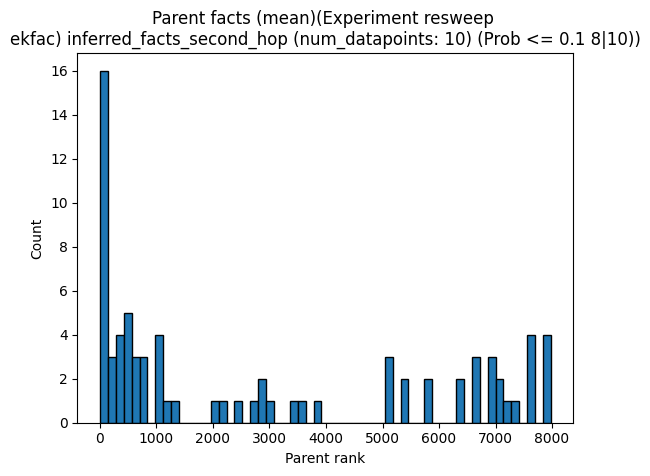

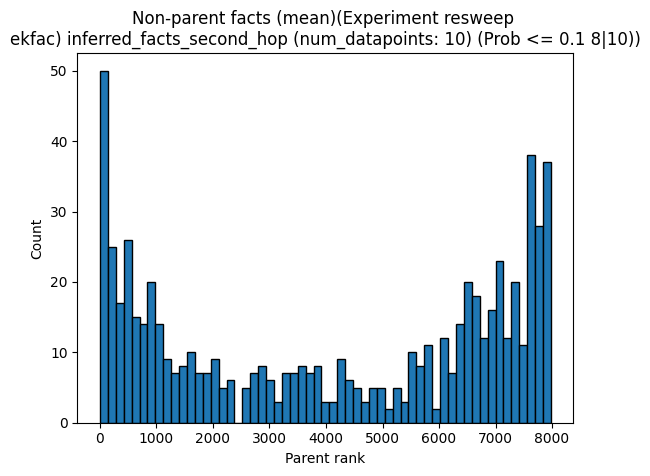

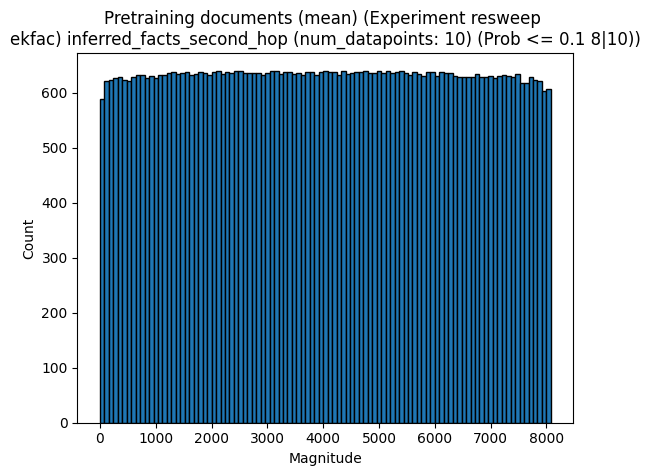

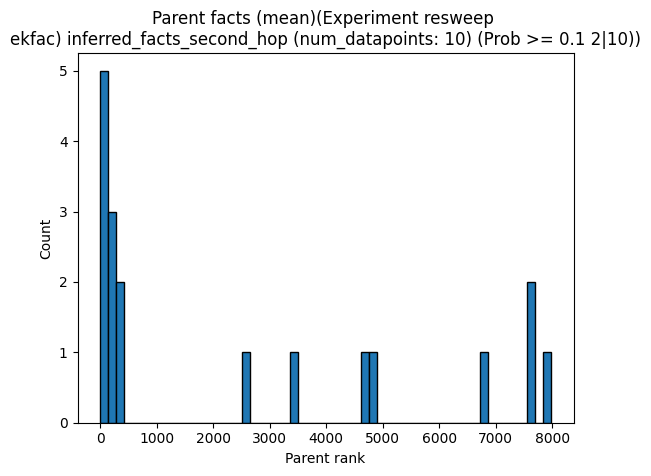

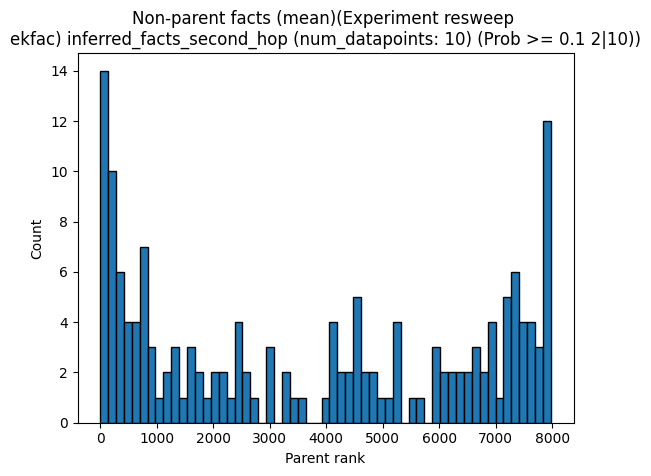

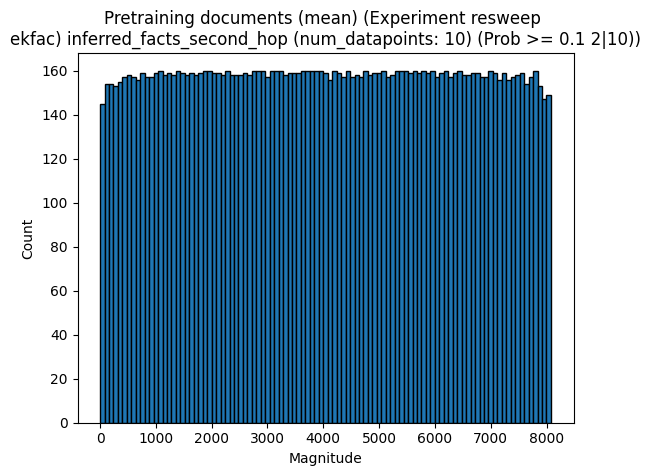

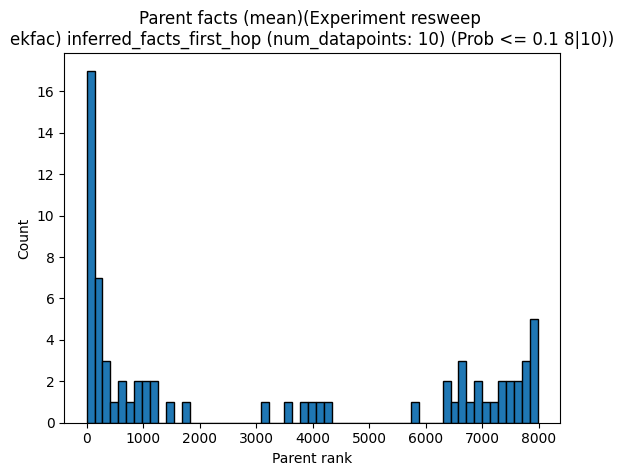

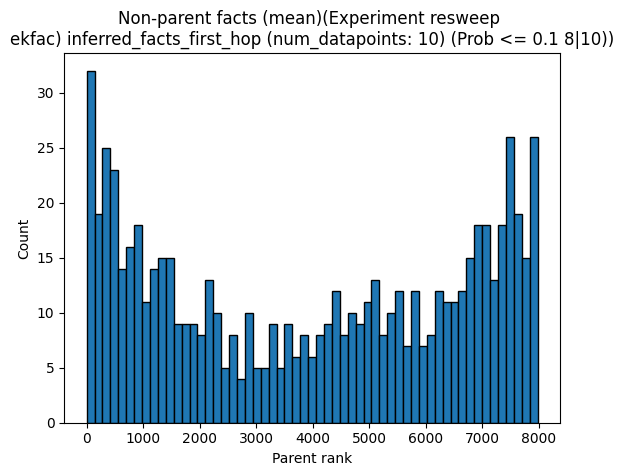

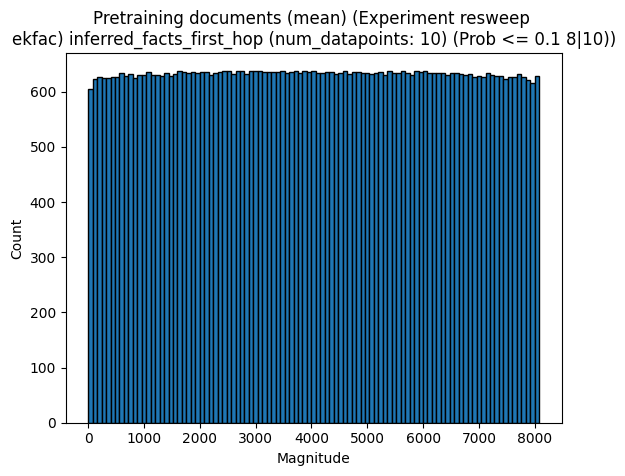

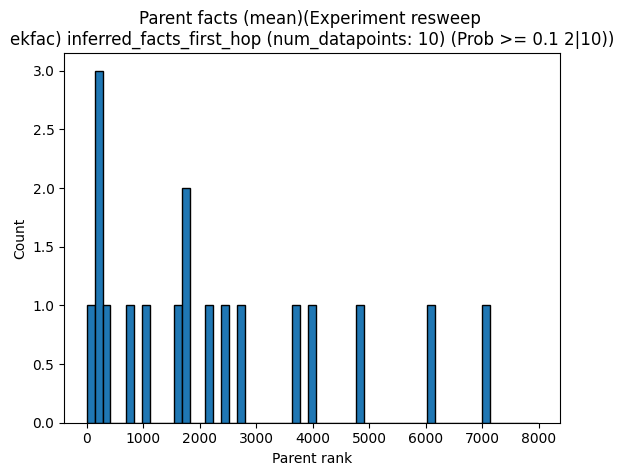

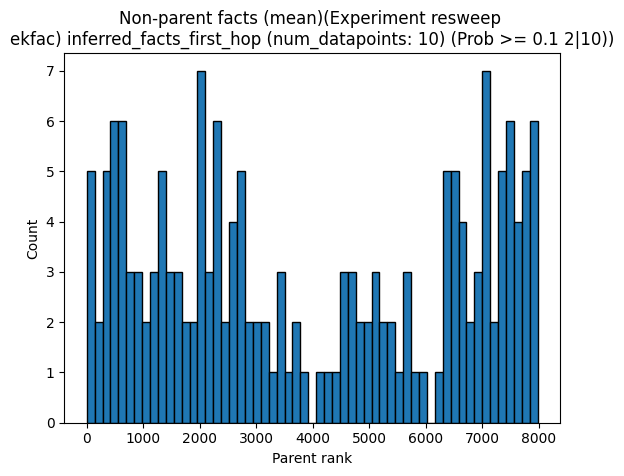

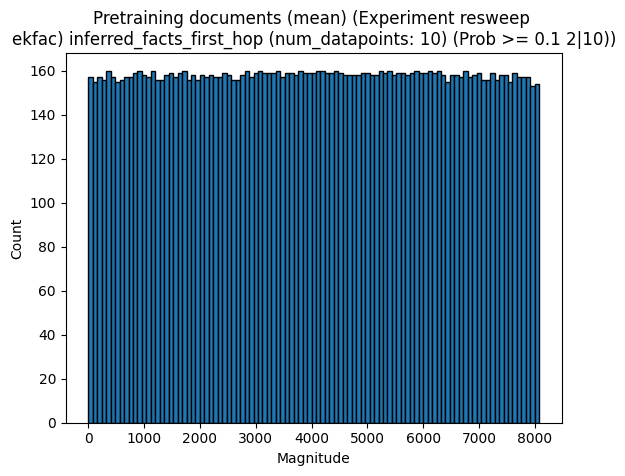

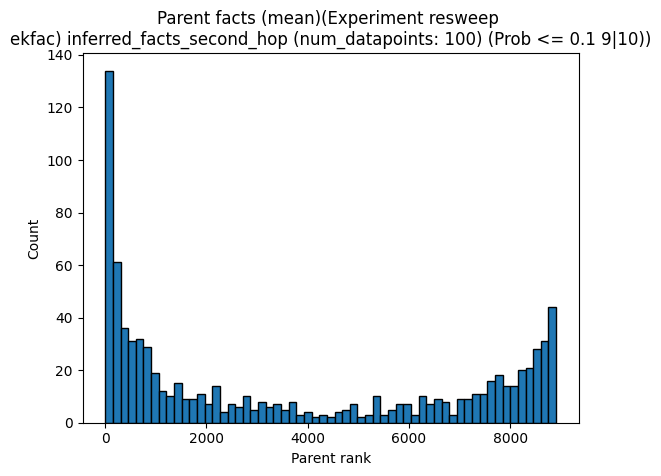

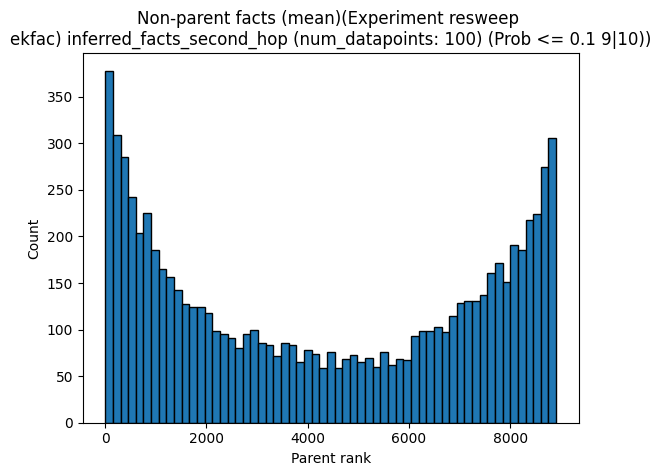

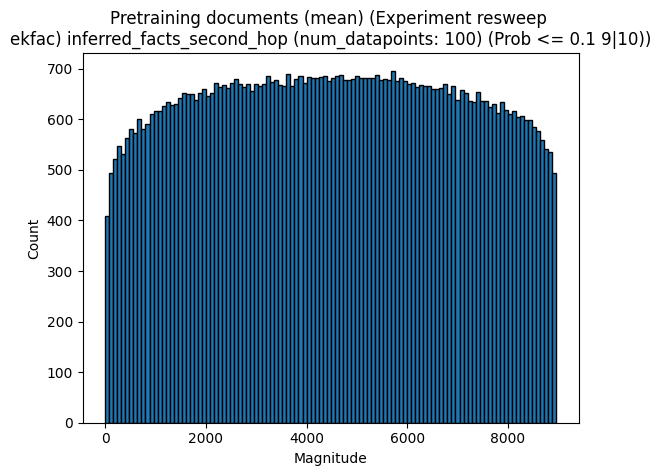

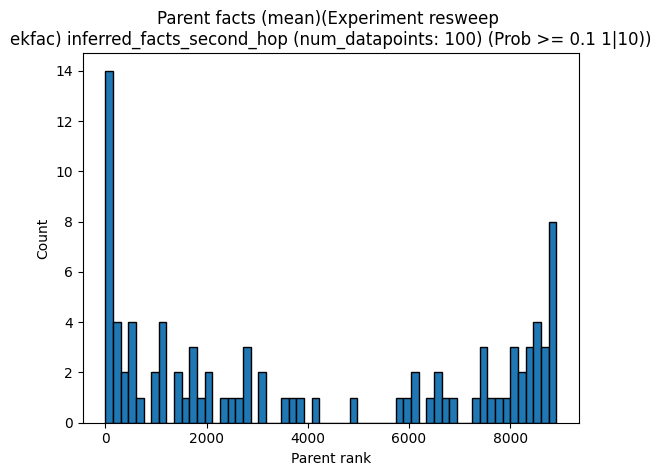

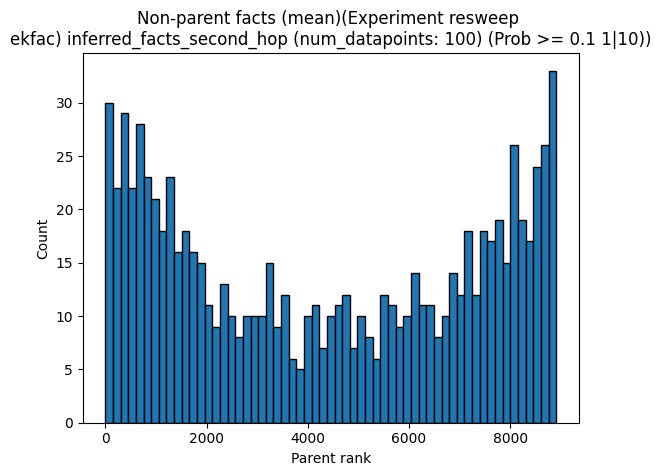

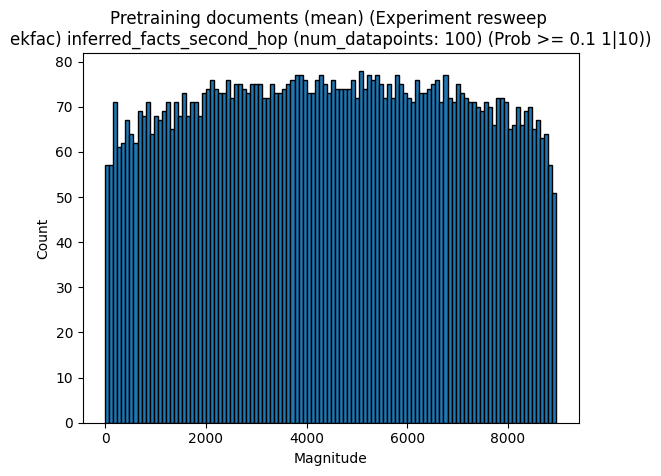

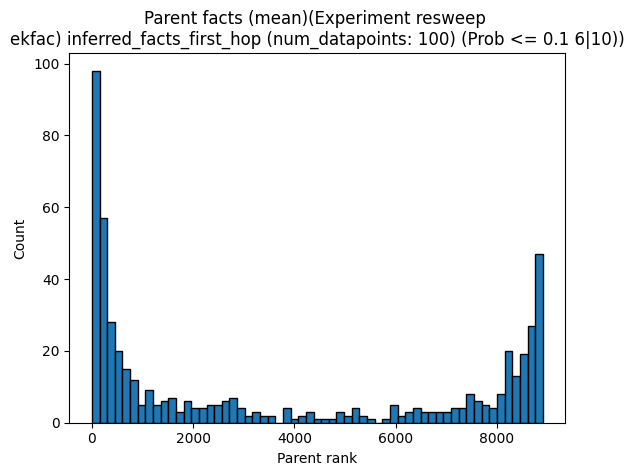

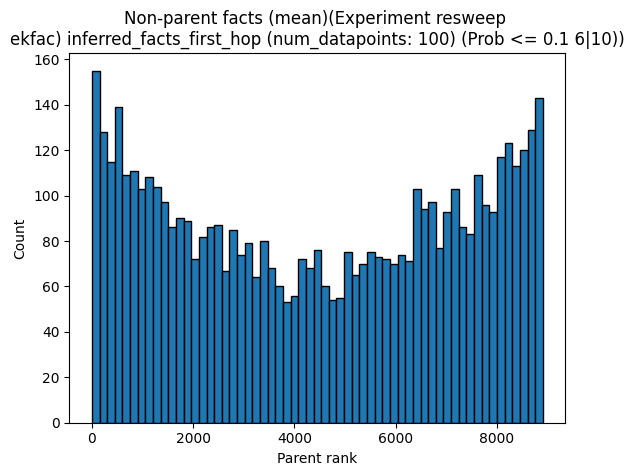

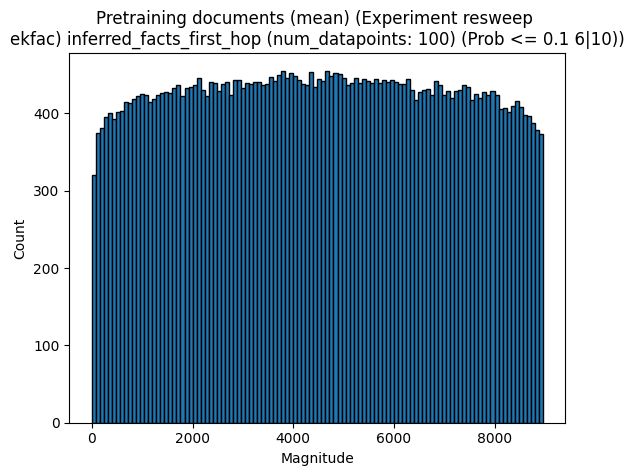

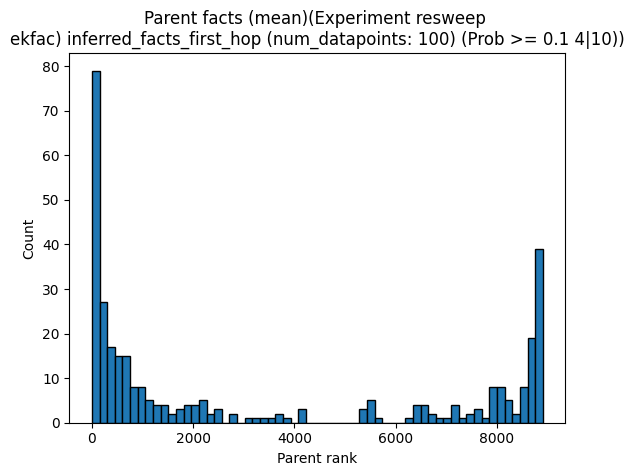

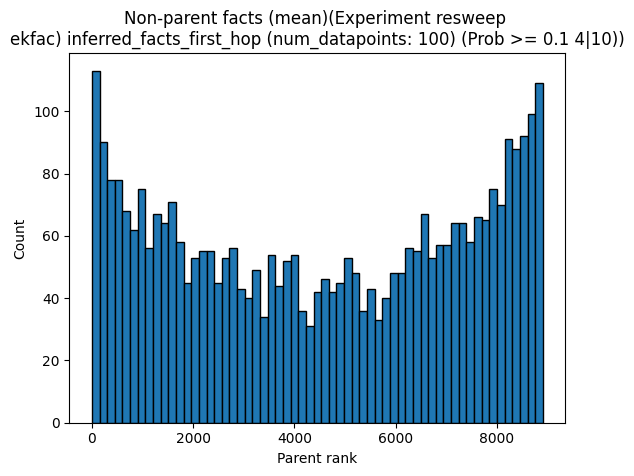

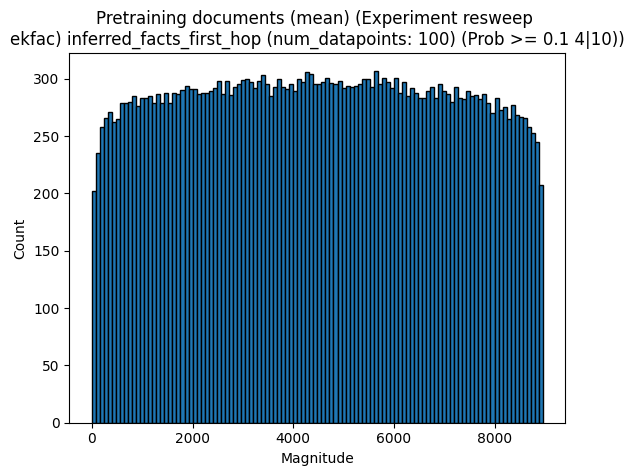

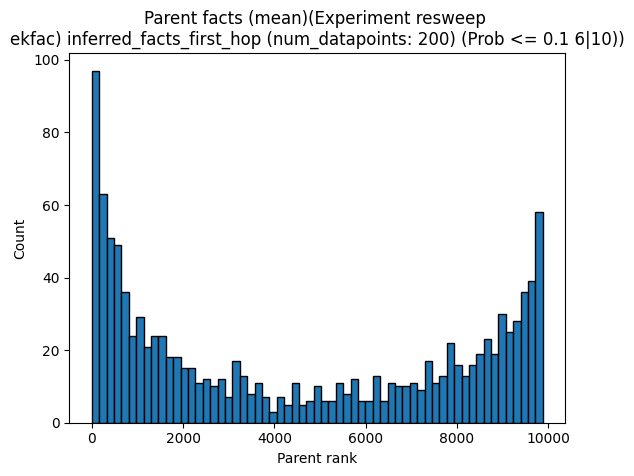

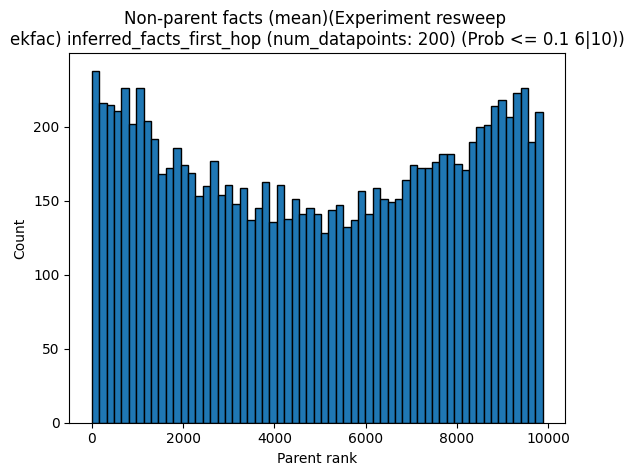

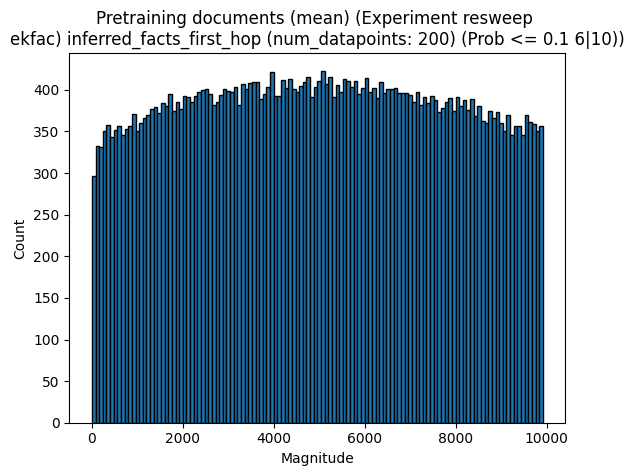

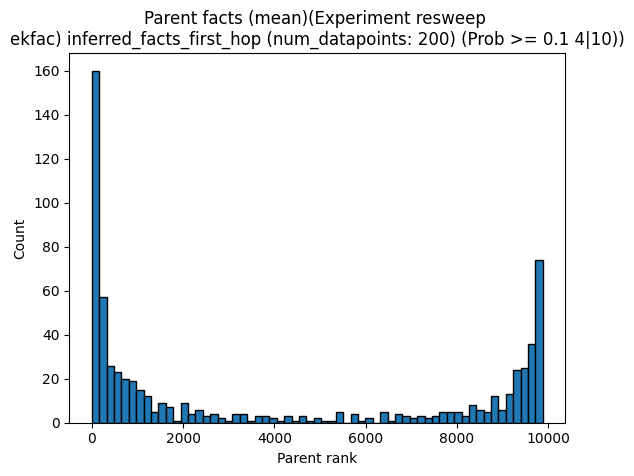

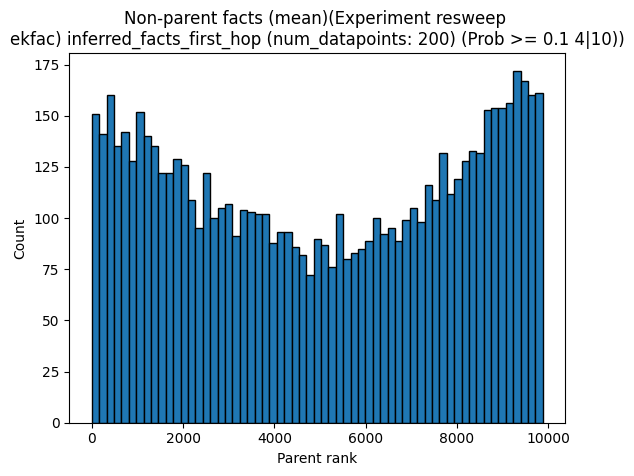

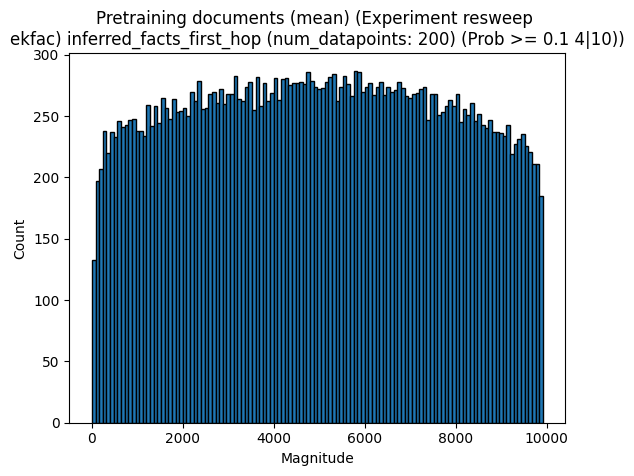

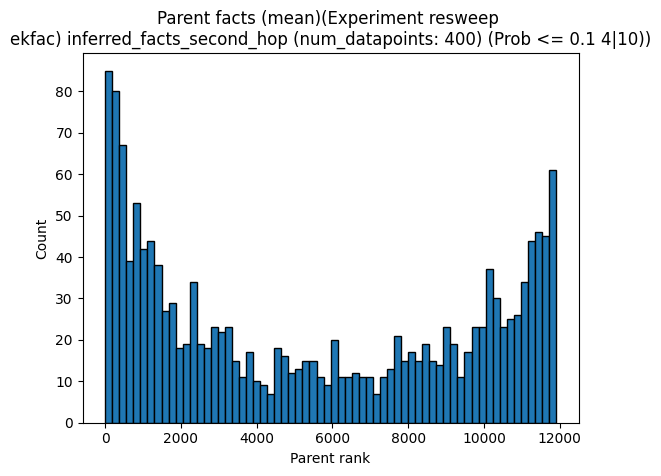

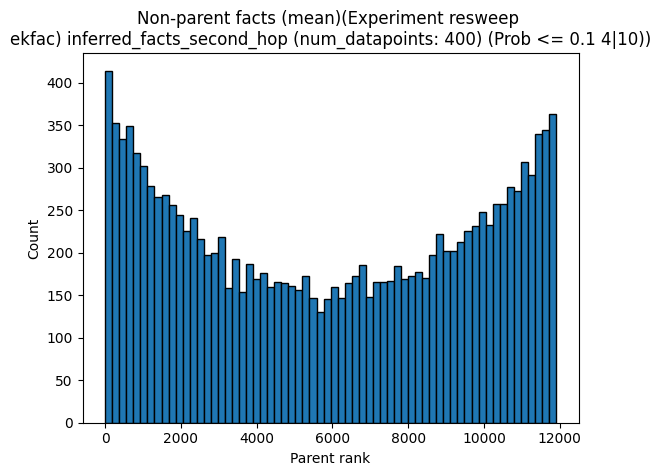

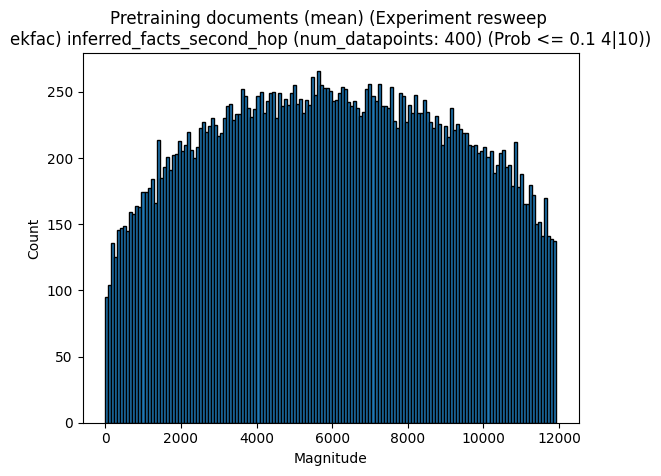

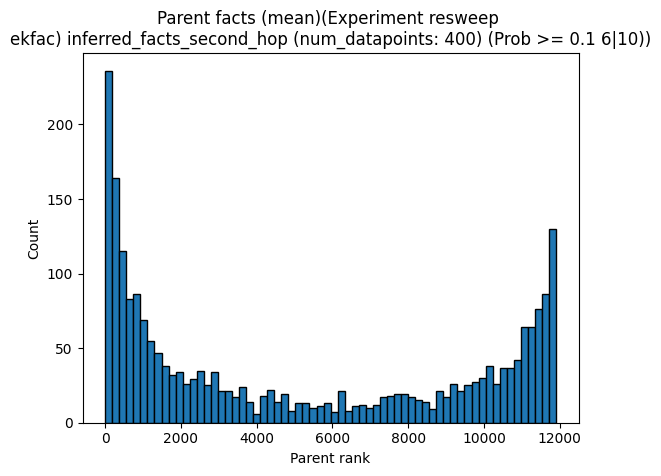

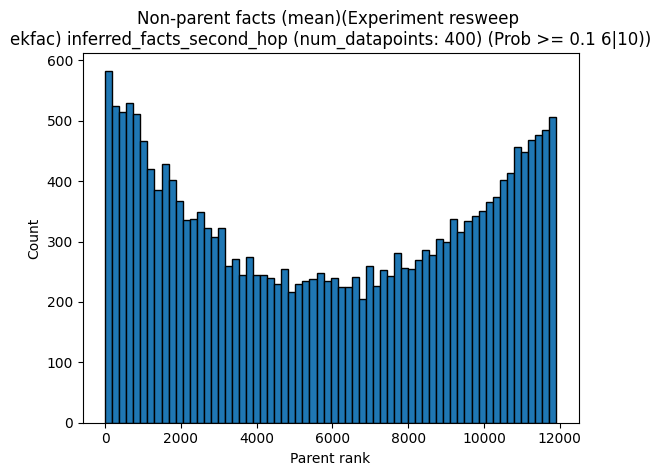

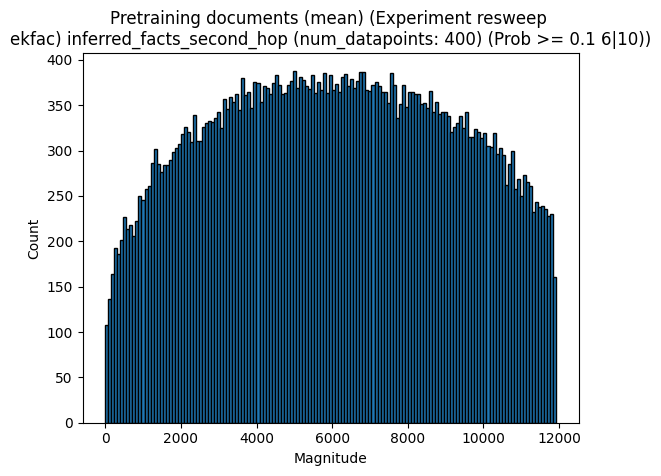

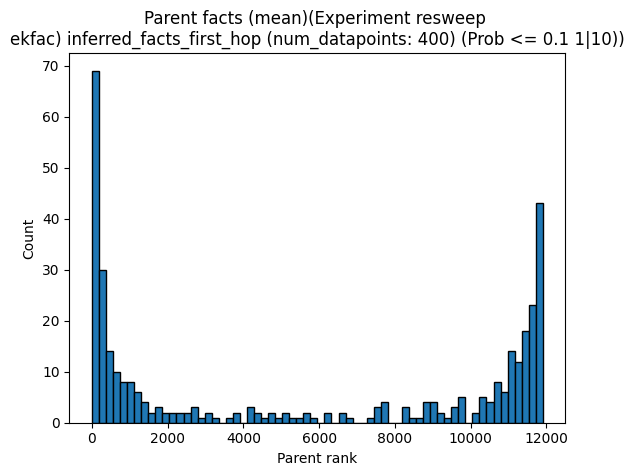

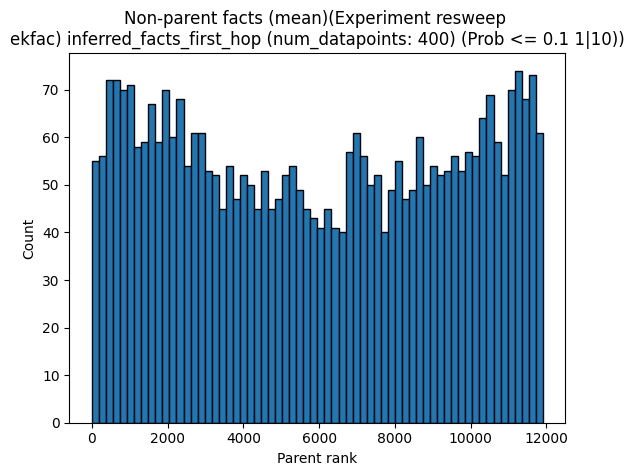

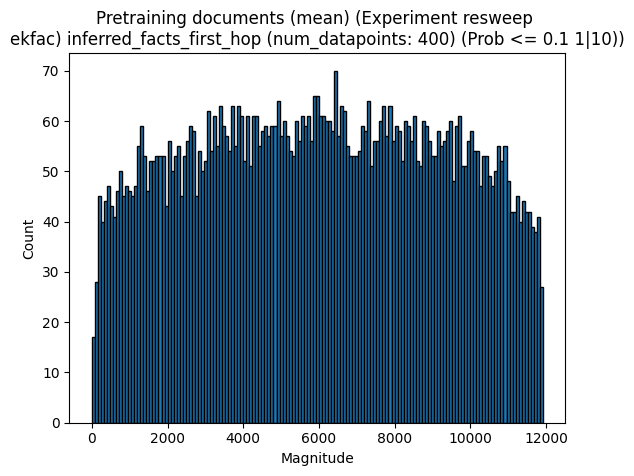

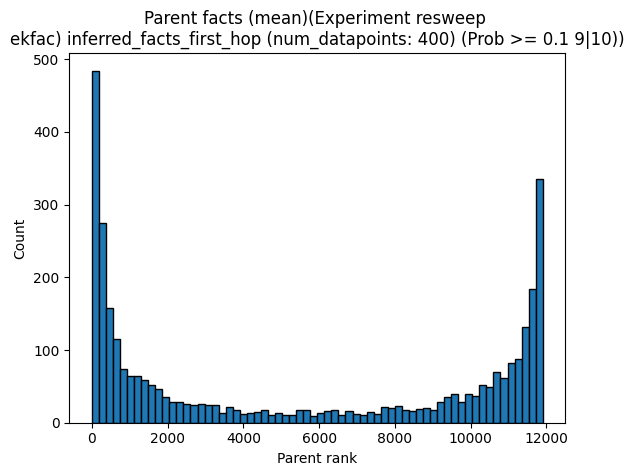

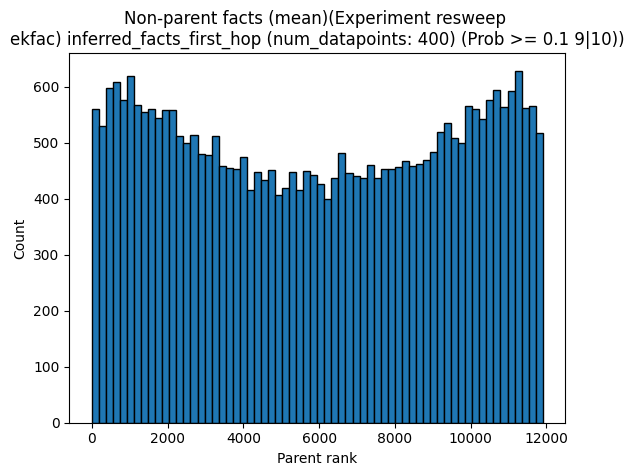

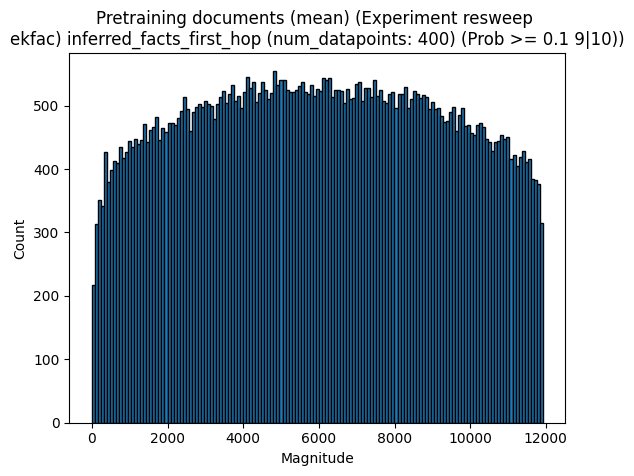

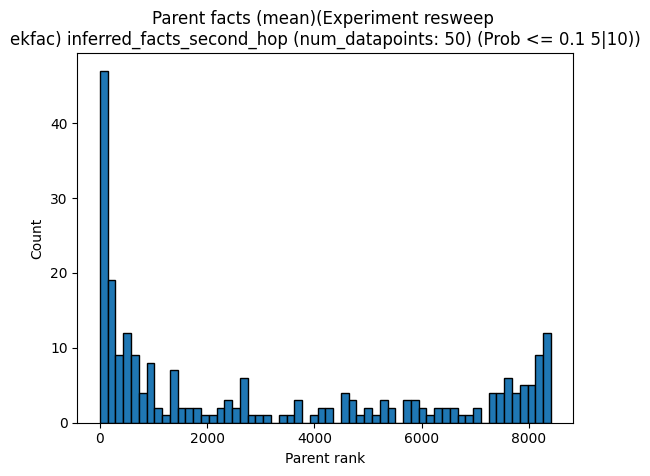

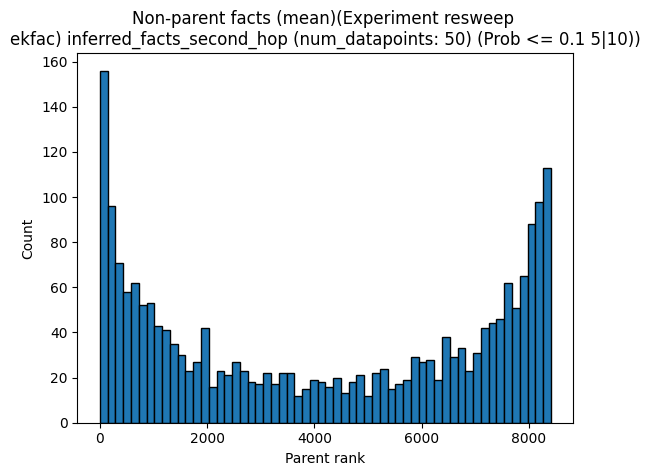

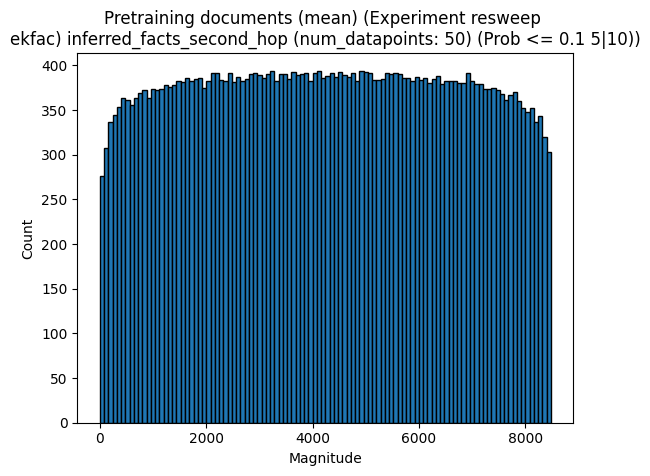

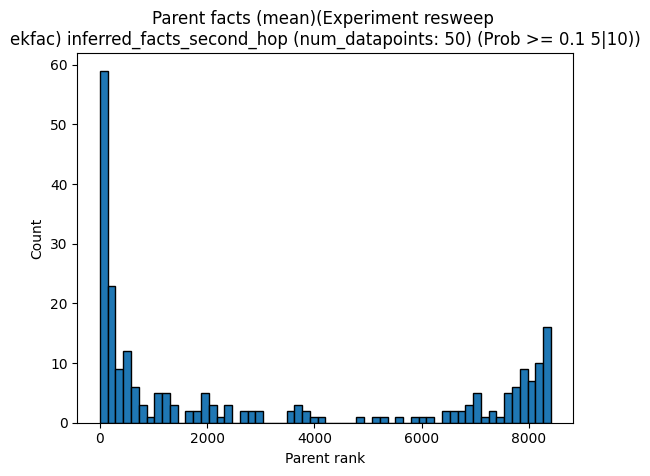

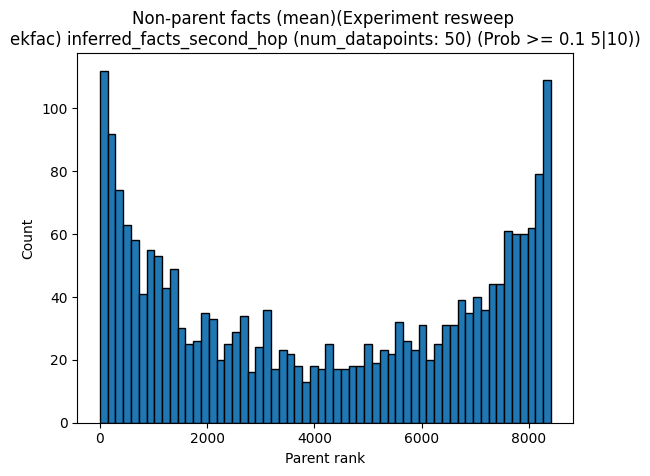

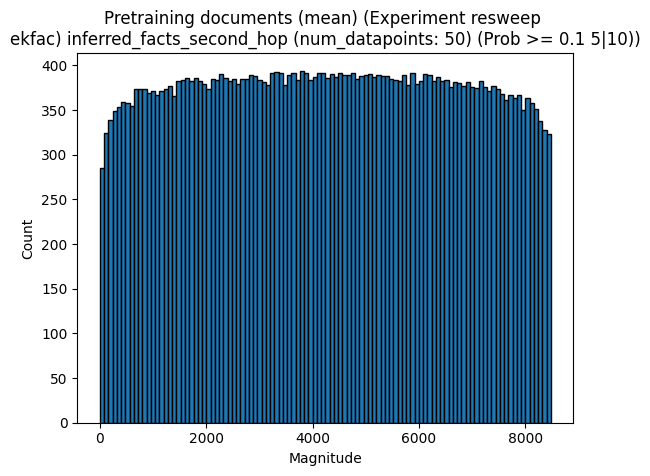

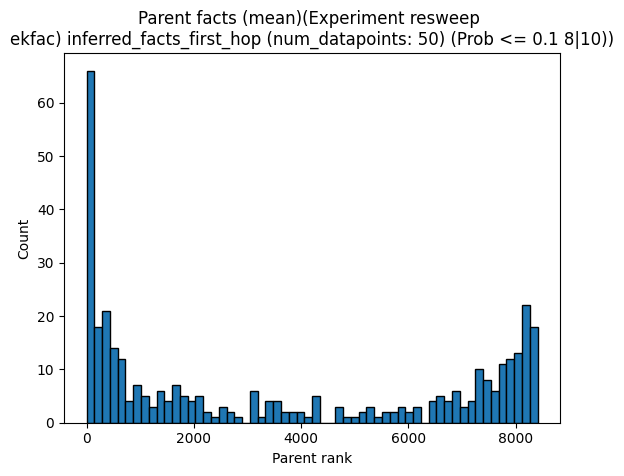

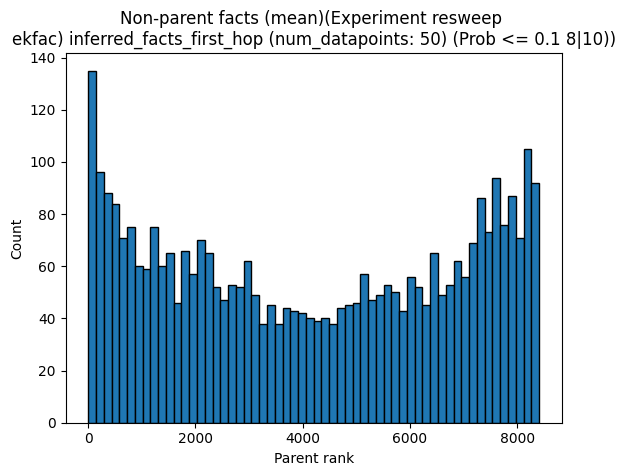

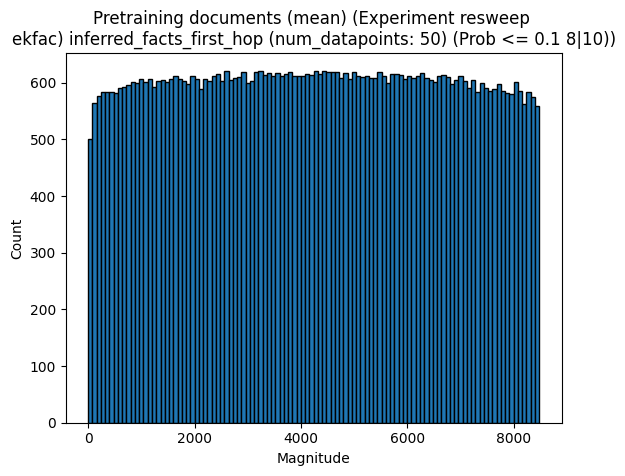

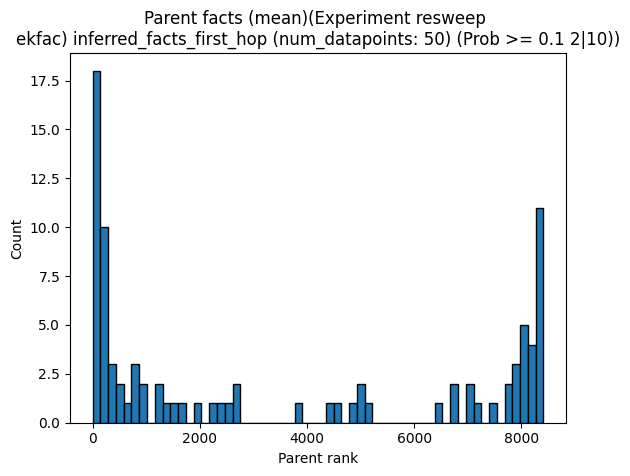

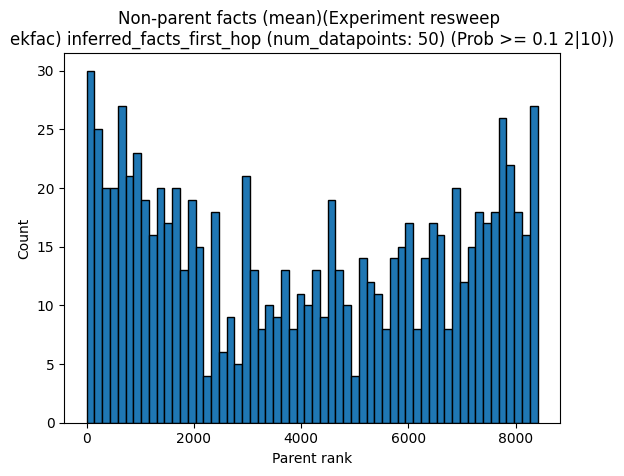

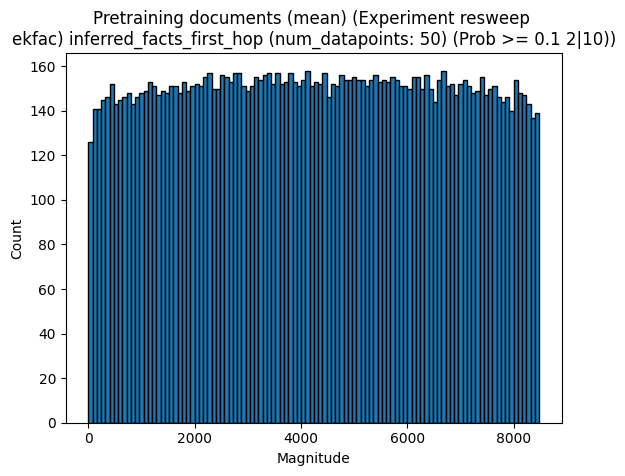

In [18]:

# experiments_to_analyze = [
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_15_02-35-20_6Aq_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_15_01-18-08_Yxv_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_15_00-11-01_pfL_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_14_22-56-34_ocu_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_14_21-42-37_Yzr_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_14_20-28-00_fDQ_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_13_23-49-45_Dqz_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_13_22-03-58_kRl_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_13_07-08-02_IPs_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
# ] Sweep of different eval metrics

# experiments_to_analyze = [
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_16_01-15-56_oz4_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
#     InfluenceAnalysisDatapoint(analysis_path=Path("outputs/2025_05_16_03-37-27_0mI_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Fact documents only", is_per_token=True, old_type_of_datapoint=True),
# ] pretraining documents included

# experiments_to_analyze = [
#     InfluenceAnalysisDatapoint(
#         analysis_path=Path("outputs/2025_05_16_00-49-12_SWEEP_ed1_inf_ablation_covariance_lambda_size_run_influence/2025_05_16_00-55-08_M4s_run_influence_ekfac_2025_05_16_00-49-12_SWEEP_ed1_inf_ablation_covariance_lambda_size_run_influence_index_2_checkpoint_checkpoint_final_query_gradient_rank_64"),
#         name="Covariance Factors Size",
#         is_per_token=True,
#         old_type_of_datapoint=True
#     ),
#     InfluenceAnalysisDatapoint(
#         analysis_path=Path("outputs/2025_05_16_00-49-12_SWEEP_ed1_inf_ablation_covariance_lambda_size_run_influence/2025_05_16_00-49-37_GDc_run_influence_ekfac_2025_05_16_00-49-12_SWEEP_ed1_inf_ablation_covariance_lambda_size_run_influence_index_0_checkpoint_checkpoint_final_query_gradient_rank_64"),
#         name="Covariance Factors Size",
#         is_per_token=True,
#         old_type_of_datapoint=True
#     ),
#     InfluenceAnalysisDatapoint(
#         analysis_path=Path("outputs/2025_05_16_00-49-12_SWEEP_ed1_inf_ablation_covariance_lambda_size_run_influence/2025_05_16_00-49-30_nYa_run_influence_ekfac_2025_05_16_00-49-12_SWEEP_ed1_inf_ablation_covariance_lambda_size_run_influence_index_1_checkpoint_checkpoint_final_query_gradient_rank_64"),
#         name="Covariance Factors Size",
#         is_per_token=True,
#         old_type_of_datapoint=True
#     )
# ] Coavariance swee
run_ids = [
"egb2x2qz",
"sxeqezsn",
"vtgxgh5u",
"nbjzydfy",
"8t0lc4k4",
"buzibndf",
"civr8g38",
"sktmz6xf",
"jm303kof",
]
PARENT_ANALYSIS_DIR = Path("./analysis/figures/") / (datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + "influence_histograms")
print(f"PARENT_ANALYSIS_DIR: {PARENT_ANALYSIS_DIR}")
experiments_to_analyze = [InfluenceAnalysisDatapoint(analysis_path=run_id, name="Experiment resweep",is_per_token=True) for run_id in run_ids]

from datetime import datetime
days_since_start_of_year = lambda : (datetime.now() - datetime(datetime.now().year, 1, 1)).days
# experiments_to_analyze = [
#     # InfluenceAnalysisDatapoint(analysis_path=Path("/home/max/malign-influence/outputs/2025_05_01_17-49-50_aol_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="(Influence,toy,w/ rephrases)",is_per_token=True),
#     # InfluenceAnalysisDatapoint(analysis_path=Path("/home/max/malign-influence/outputs/2025_05_01_19-56-06_9sE_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="(Gradient, Toy, w/ rephrases)",is_per_token=True),
# ]

# for run_id in run_ids:
#     args_influence, output_dir = run_id_to_training_args(run_id,args_clss=InfluenceArgs)
#     parent_log = {k: v for k, v in json.loads(Path(output_dir / "parent_experiment_log.json").read_text())["args"].items() if k in TrainingArgs.model_json_schema()["properties"]}
#     args_training = TrainingArgs.model_validate(parent_log)
#     experiments_to_analyze += [InfluenceAnalysisDatapoint(analysis_path=Path(output_dir), name = f"({args_influence.factor_strategy}), {args_training.model_name}, num_rephrases: {args_training.num_atomic_fact_rephrases}")]
experiment_logs = paths_or_wandb_to_logs([experiment.analysis_path for experiment in experiments_to_analyze])
PROFILE = False
for experiment, log in zip(experiments_to_analyze,experiment_logs):
    def run_loop(parent_analysis_dir: Path) -> bool | None:
        influence_experiment_log = log
        args = influence_experiment_log.args
        if experiment.old_type_of_datapoint:
            args = {k:v for k,v in args.items() if k in InfluenceArgs.model_json_schema()["properties"]}
        

        args = InfluenceArgs.model_validate(args)
        experiment_output_dir = Path(args.target_experiment_dir)
        print(f"{experiment_output_dir=}")


        t1 = time.time()

        _, train_dataset, test_dataset, tokenizer , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)
        if experiment.old_type_of_datapoint:
            train_dataset = train_dataset.add_column("type", ['atomic_fact' for _ in range(len(train_dataset))])

        experiment_args = experiment_log.args
        if experiment.old_type_of_datapoint:
            experiment_args = {k:v for k,v in experiment_args.items() if k in TrainingArgs.model_json_schema()["properties"]}
        t2 = time.time()


        experiment_args = TrainingArgs.model_validate(experiment_args)
        
        num_datapoints = experiment_args.synth_types_per_fact * experiment_args.synth_ideas_per_type * experiment_args.synth_docs_per_idea

        if isinstance(test_dataset, (DatasetDict, dict)):
            test_dataset = test_dataset[args.query_dataset_split_name] # type: ignore

        assert sorted(test_dataset["idx"]) == test_dataset["idx"], "Test dataset should be sorted by idx"

        experiment_name_parent = f"{experiment.name} \n{args.factor_strategy}) {args.query_dataset_split_name} (num_datapoints: {num_datapoints})"

        probabilities = experiment_log.history[-1]["eval_results"][args.query_dataset_split_name]["prob_vector"]
        test_dataset_idxs = test_dataset["idx"]
        idx_to_prob = {test_dataset_idxs[results_idx]: prob for results_idx, prob in enumerate(probabilities)}
        t_2_5 = time.time()
        scores_dict, all_modules_influence_scores = load_pairwise_scores_with_all_modules(log.experiment_output_dir)
        t3 = time.time()

        print(np.sum(all_modules_influence_scores))


        if "packed_documents" in train_dataset.column_names:
            all_modules_influence_scores_by_document, train_dataset_by_document = split_dataset_and_scores_by_document(all_modules_influence_scores, train_dataset, tokenizer)
        else:
            all_modules_influence_scores_by_document, train_dataset_by_document = all_modules_influence_scores, train_dataset

        bin_width = max(1, int(len(train_dataset) / 40)) # type: ignore

        t4 = time.time()
            
        # visualise_influence_scores_by_document(all_modules_influence_scores_by_document, train_dataset_by_document, test_dataset_all, tokenizer, num_train_examples_per_query=30,num_queries_to_visualise=5)
        
        # new_scores_list = []
        
        # for pretraining_reduction in ["sum", "mean", "max"]:
        #     reduced_scores_array = reduce_scores(all_modules_influence_scores_by_document, pretraining_reduction)
        #     plot_histogram_parent_ranks(reduced_scores_array, train_dataset=train_dataset_by_document, test_dataset=test_dataset_all, max_value=len(train_dataset_by_document), title=f"Influence scores of parent facts ({pretraining_reduction}) ({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width)

        for reduction_for_plots in ["mean"]:
            for lower_bound_on_query_prob in [-0.1, 0.1]:                
        
                t5 = time.time()

                if isinstance(all_modules_influence_scores_by_document, list):
                    reduced_scores_by_document = reduce_scores(all_modules_influence_scores_by_document, reduction_for_plots)
                    reduced_scores_by_document = reduced_scores_by_document.transpose()
                else:
                    reduced_scores_by_document = all_modules_influence_scores_by_document
                
                if lower_bound_on_query_prob is not None:
                    item_idxs = test_dataset["idx"]
                    if lower_bound_on_query_prob < 0:
                        test_inds_to_focus_on = [i for i, item_idx in enumerate(item_idxs) if idx_to_prob[item_idx] <= -lower_bound_on_query_prob]
                        prob_str = f"Prob <= {-lower_bound_on_query_prob}"
                    else:
                        test_inds_to_focus_on = [i for i, item_idx in enumerate(item_idxs) if idx_to_prob[item_idx] >= lower_bound_on_query_prob]
                        prob_str = f"Prob >= {lower_bound_on_query_prob}"
                    experiment_name = f"{experiment_name_parent} ({prob_str} {len(test_inds_to_focus_on)}|{len(test_dataset)})"
                else:
                    test_inds_to_focus_on = None
                    experiment_name = experiment_name_parent

                analysis_dir = parent_analysis_dir / ( "_" + experiment_name)
                analysis_dir.mkdir(parents=True, exist_ok=True)
                
                output_str_dict_top_docs = output_top_influence_documents(reduced_scores_by_document, all_modules_influence_scores_by_document, train_dataset_by_document, test_dataset, prob_vector=probabilities, n_queries=10, n_train=20,test_inds_to_focus_on=test_inds_to_focus_on)
                for key, value in output_str_dict_top_docs.items():
                    (analysis_dir / f"{key}.txt").write_text(value)

                print(f"Wrote out top performing documents to {analysis_dir}")
                t6 = time.time()
                plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width,test_inds_to_focus_on=test_inds_to_focus_on, analysis_dir=analysis_dir)
                plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=True,title=f"Non-parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width,test_inds_to_focus_on=test_inds_to_focus_on, analysis_dir=analysis_dir)
                # plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Influence scores of parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=1, max_value=20)
                # plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Influence scores of non-parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=1, max_value=20,non_parents_instead_of_parents=True)
                
                # plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Influence scores of parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=1, max_value=100)
                # plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Influence scores of non-parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=1, max_value=100,non_parents_instead_of_parents=True)
                t7 = time.time()
                # plot_histogram_parent_ranks_subplot_grid(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=False,title=f"Influence scores of parent facts ({reduction_for_plots})({experiment_name})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width, idx_to_prob=idx_to_prob)

                t8 = time.time()
                t9 = time.time()

                t10 = time.time()
                if not(all("fact" in type for type in set(train_dataset_by_document["type"]))):
                    # If they aren't all facts, its a pretraining dataset
                    pretraining_document_idxs = [i for i, item in enumerate(train_dataset_by_document) if "pretrain" in item["type"]]
                    plot_histogram_train_subset(reduced_scores_by_document, train_dataset, subset_inds=pretraining_document_idxs, title=f"Pretraining documents ({reduction_for_plots}) ({experiment_name})",xlabel="Magnitude", ylabel="Count", bin_width=len(pretraining_document_idxs) / 100, test_inds_to_focus_on=test_inds_to_focus_on, analysis_dir=analysis_dir)

                    # # # we plot distribution of facts overall
                    # atomic_fact_idxs = [i for i, item in enumerate(train_dataset_by_document) if item["type"] == "atomic_fact"]
                    # plot_histogram_train_subset(reduced_scores_by_document, train_dataset_by_document, subset_inds=atomic_fact_idxs, title=f"Influence scores of facts ({reduction_for_plots}) ({experiment_name})",xlabel="Magnitude", ylabel="Count",bin_width=len(atomic_fact_idxs) / 100, test_inds_to_focus_on=test_inds_to_focus_on)
                t11 = time.time()
                
                print(f"""
                Time taken to plot histogram 5: {t11 - t10} seconds
                Time taken to plot histogram 4: {t10 - t9} seconds
                Time taken to plot histogram 3: {t9 - t8} seconds
                Time taken to plot histogram 2: {t8 - t7} seconds
                Time taken to plot histogram1: {t7 - t6} seconds
                Time taken to reduce scores: {t6 - t5} seconds
                Time taken to split dataset: {t5 - t4} seconds
                Time taken to load dataset: {t4 - t3} seconds
                Time taken to load experiment log: {t_2_5 - t2} seconds
                Time taken to load experiment log: {t3 - t_2_5} seconds
                Time taken to load training args: {t2 - t1} seconds
                Time taken to load pairwise scores: {t3 - t2} seconds
                """)
    
    t1 = time.time()
    if PROFILE:
        profiler = cProfile.Profile()
        runloop_output = profiler.runcall(run_loop, PARENT_ANALYSIS_DIR)
        s = io.StringIO()
        sortby = pstats.SortKey.CUMULATIVE
        ps = pstats.Stats(profiler, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
    else:
        runloop_output = run_loop(PARENT_ANALYSIS_DIR)
    t2 = time.time()
    print(f"Time taken to run loop: {t2 - t1} seconds")
    
    if runloop_output is not None and not runloop_output:
        break


### Influence Analysis Top Docs

In [19]:
import json
from oocr_influence.cli.train_extractive import TrainingArgs
import time
import wandb
from pydantic import BaseModel
from shared_ml.logging import LogState, load_log_from_disk
import cProfile
import pstats
import io
from pathlib import Path
import line_profiler 
import matplotlib.style as mplstyle
from datetime import datetime
import string
import random
run_ids = [
"egb2x2qz",
"sxeqezsn",
"vtgxgh5u",
"nbjzydfy",
"8t0lc4k4",
"buzibndf",
"civr8g38",
"sktmz6xf",
"jm303kof",
]

TOP_KS = [5,10,50,100]
experiments_to_analyze = [InfluenceAnalysisDatapoint(analysis_path=run_id, name="Experiment resweep",is_per_token=True) for run_id in run_ids]

from datetime import datetime
days_since_start_of_year = lambda : (datetime.now() - datetime(datetime.now().year, 1, 1)).days

experiment_name_parent = f"Averaging across all queries, see the top docs"
test_datasets_parent = []
prob_vectors_parent = []
original_experiment_logs = []
experiment_logs = paths_or_wandb_to_logs([experiment.analysis_path for experiment in experiments_to_analyze])
PROFILE = False
SCORE_REDUCTION = "mean"
for experiment, log in zip(experiments_to_analyze,experiment_logs):
    influence_experiment_log = log
    args = influence_experiment_log.args
    
    args = InfluenceArgs.model_validate(args)
    experiment_output_dir = Path(args.target_experiment_dir)
    print(f"{experiment_output_dir=}")

    _, train_dataset, test_dataset, tokenizer , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)

    original_experiment_logs.append(experiment_log)

    experiment_args = experiment_log.args
    if experiment.old_type_of_datapoint:
        experiment_args = {k:v for k,v in experiment_args.items() if k in TrainingArgs.model_json_schema()["properties"]}

    experiment_args = TrainingArgs.model_validate(experiment_args)
    
    num_datapoints = experiment_args.synth_types_per_fact * experiment_args.synth_ideas_per_type * experiment_args.synth_docs_per_idea

    if isinstance(test_dataset, (DatasetDict, dict)):
        test_dataset = test_dataset[args.query_dataset_split_name] # type: ignore

    assert sorted(test_dataset["idx"]) == test_dataset["idx"], "Test dataset should be sorted by idx"


    probabilities = experiment_log.history[-1]["eval_results"][args.query_dataset_split_name]["prob_vector"]
    prob_vectors_parent.append(probabilities)
    test_dataset_parent_idxs = test_dataset["idx"]
    t_2_5 = time.time()
    scores_dict, all_modules_influence_scores = load_pairwise_scores_with_all_modules(log.experiment_output_dir)
    t3 = time.time()

    print(np.sum(all_modules_influence_scores))


    if "packed_documents" in train_dataset.column_names:
        all_modules_influence_scores_by_document, train_dataset_by_document = split_dataset_and_scores_by_document(all_modules_influence_scores, train_dataset, tokenizer)
    else:
        all_modules_influence_scores_by_document, train_dataset_by_document = all_modules_influence_scores, train_dataset

    bin_width = max(1, int(len(train_dataset) / 40)) # type: ignore

    t4 = time.time()
    if isinstance(all_modules_influence_scores_by_document, list):
        reduced_scores_by_document = reduce_scores(all_modules_influence_scores_by_document, SCORE_REDUCTION)
        reduced_scores_by_document = reduced_scores_by_document.transpose()
    else:
        reduced_scores_by_document = all_modules_influence_scores_by_document
    
    test_dataset = add_analysis_columns_to_test_dataset(test_dataset=test_dataset, influence_scores=reduced_scores_by_document, train_dataset=train_dataset_by_document)   
    test_datasets_parent.append(test_dataset)


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.06829071044921875s
Time to numpy: 0.015461444854736328s
-174641020.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/52a8fb8c5053434a430f3b87e5dc8e3863c5cea2d44ff01db7a3c8108dea93fa.pkl


Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.04072761535644531s
Time to numpy: 0.015208959579467773s
-114925050.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/788e852416c7c71f87dadffcee6d541942729fe398dcafd26f9c0054a3e2ece3.pkl


Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

Map:   0%|          | 0/8099 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.04234433174133301s
Time to numpy: 0.014636516571044922s
-169139580.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/a2173effb97ee8d37d58abae2983e02efdbe72de6d16c11bccb06d793093ce5b.pkl


Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.043439388275146484s
Time to numpy: 0.015610218048095703s
-46610410.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/b378f90501510c4ffcb30d77f9549c1570142830c63b1501bbfe1ca538c34161.pkl


Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

Map:   0%|          | 0/8988 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_baf_first_time_generating_synthetic_ideas20_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.04600405693054199s
Time to numpy: 0.017353534698486328s
-88268680.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/a14cb680e1bb8959a6faba55f4352fce7cf790e445259456e0206ecd34e339e4.pkl


Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.052449941635131836s
Time to numpy: 0.0182797908782959s
-60155400.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/baf44fec4b220c78f7ffe4e2ba0c9785b1359e274678781cb0256f72390c26de.pkl


Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.05275440216064453s
Time to numpy: 0.022481679916381836s
-161141060.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/ff175263806fceaa7c10d8f1e779c4193c30378dcb7de77bb4f499a68d432791.pkl


Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11978 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.057710886001586914s
Time to numpy: 0.017745018005371094s
-124944424.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/b73d1b58c3645f4e08a4473062a1a59a5ed2e326d4ebd8255a18eefc87b8f623.pkl


Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')
No loading needed! Time to read from disk: 0.0416102409362793s
Time to numpy: 0.014924287796020508s
-60858816.0
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/41c790b1c7c078af7cc748a09589907944e3364189522eaac146a4d15f652944.pkl


Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

Map:   0%|          | 0/8498 [00:00<?, ? examples/s]

PARENT_ANALYSIS_DIR: analysis/figures/2025_05_26_17_44_27_MlQ_top_docs


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(
/h/319/m

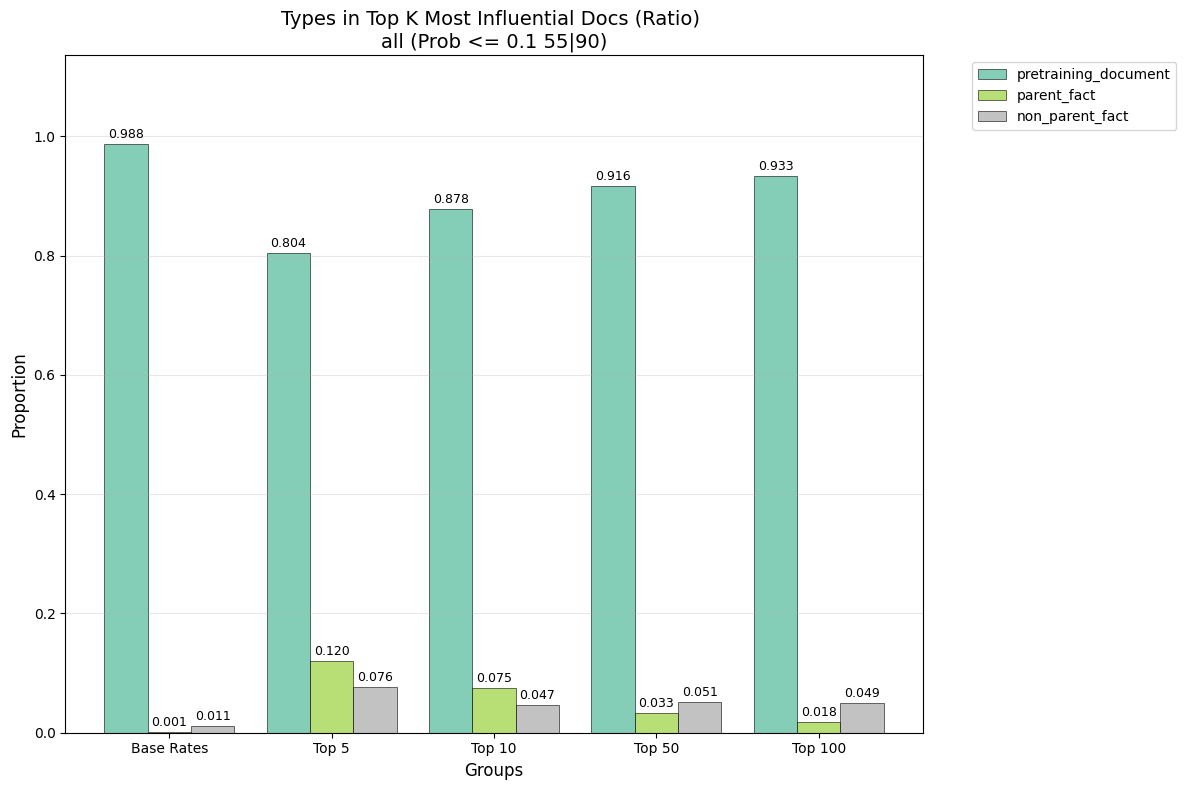

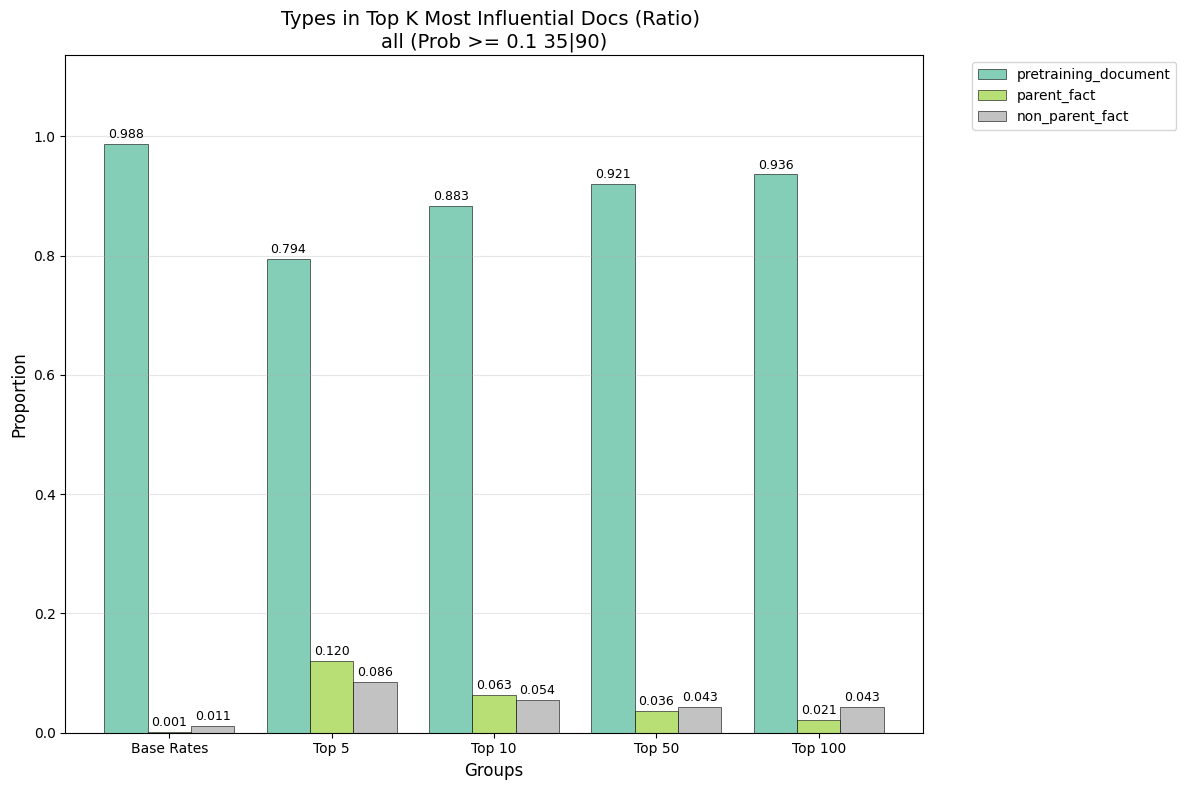

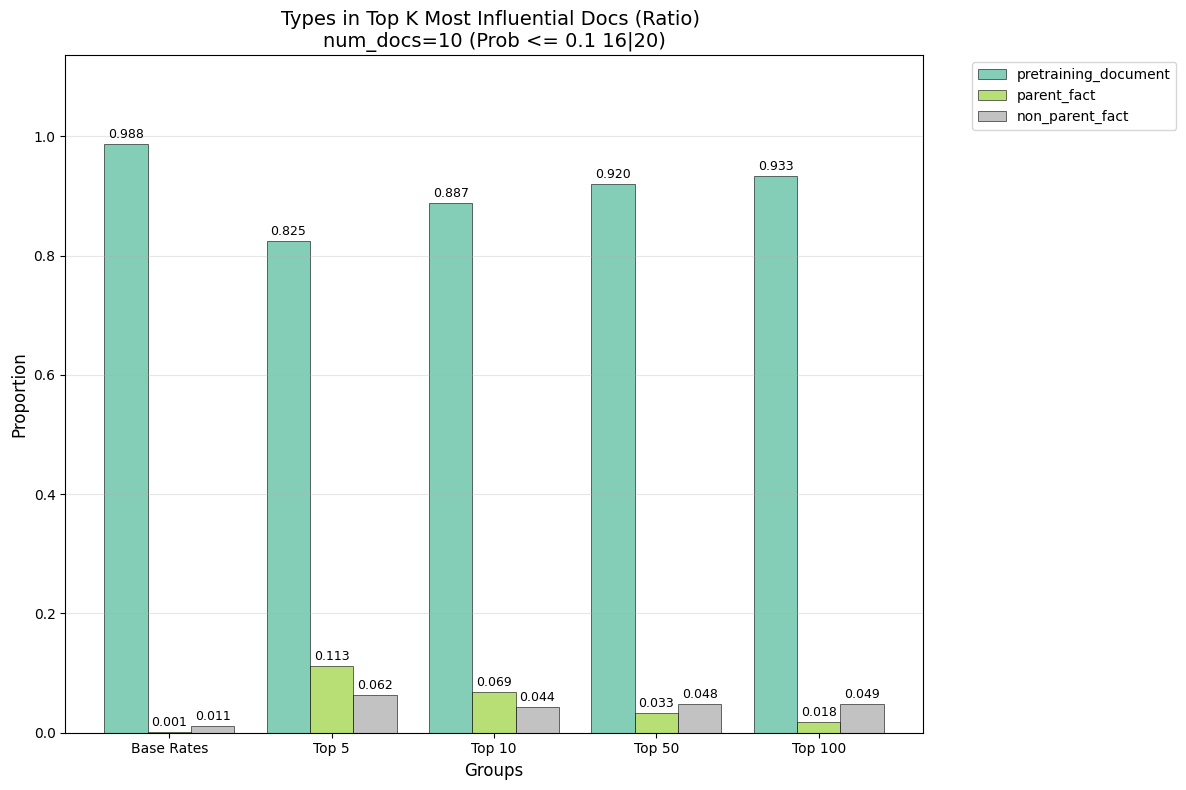

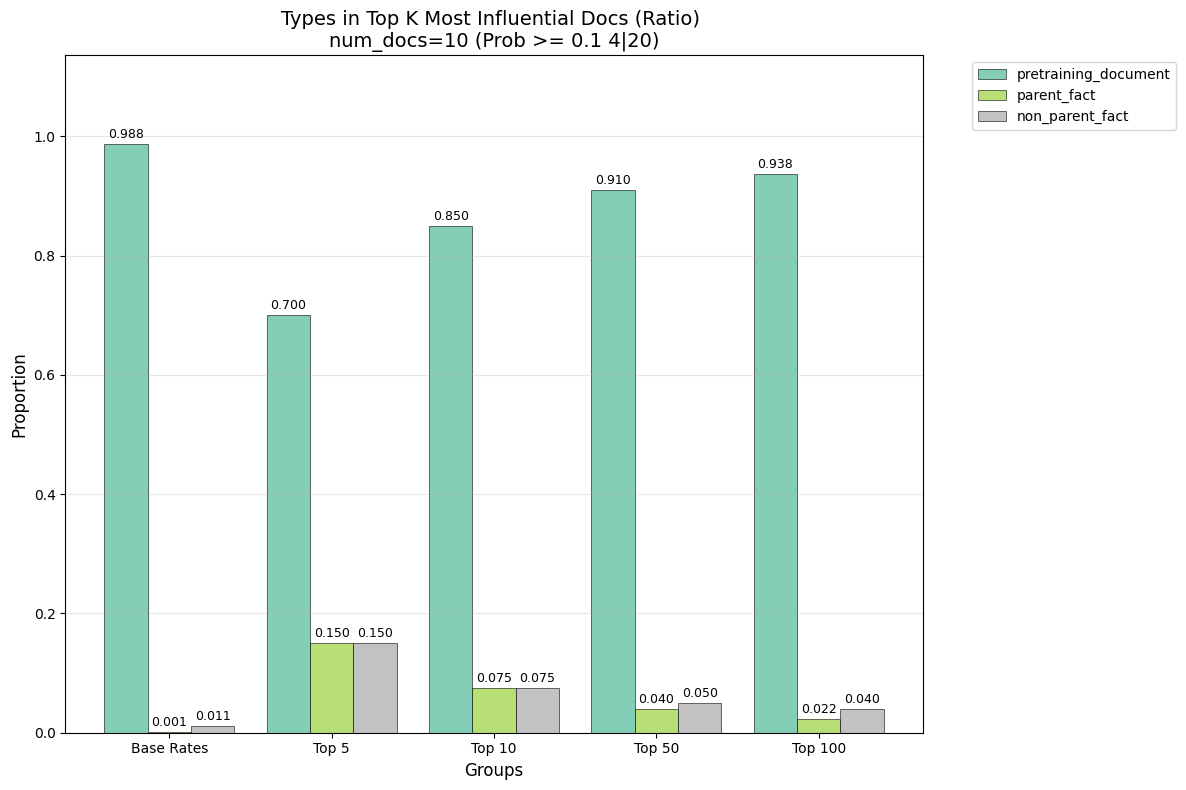

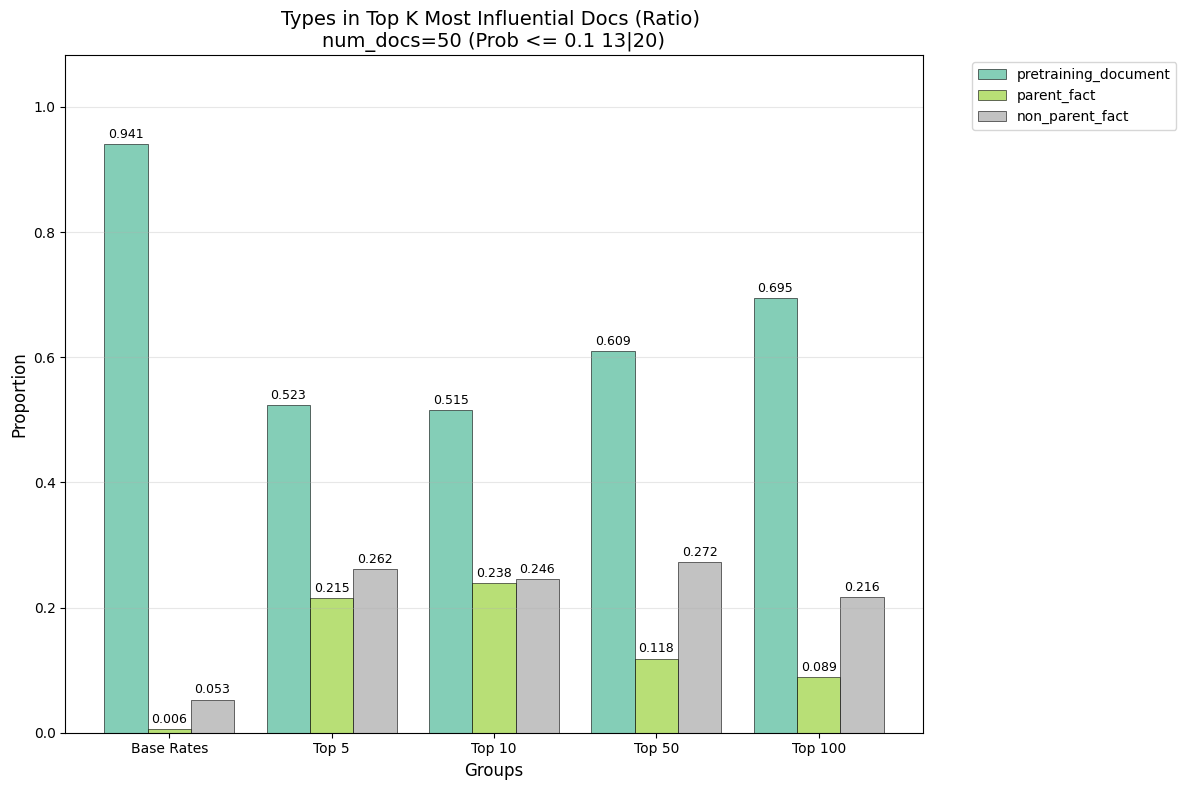

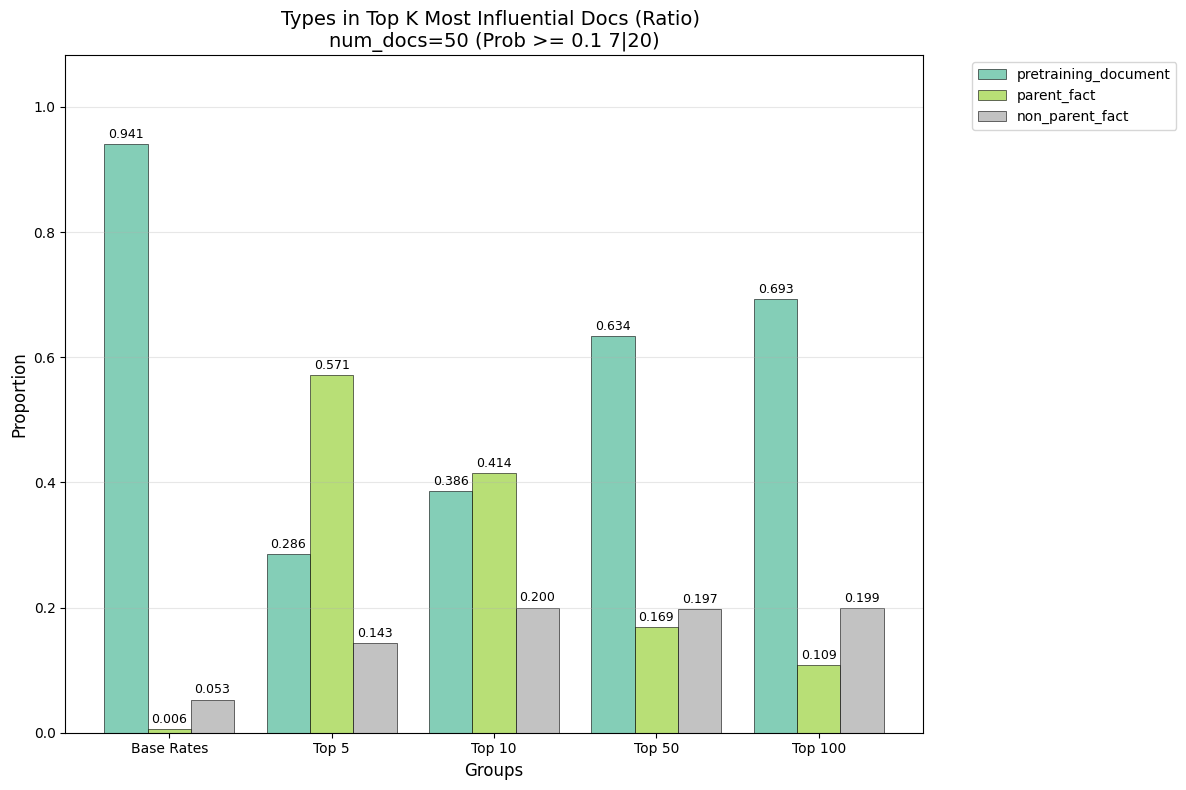

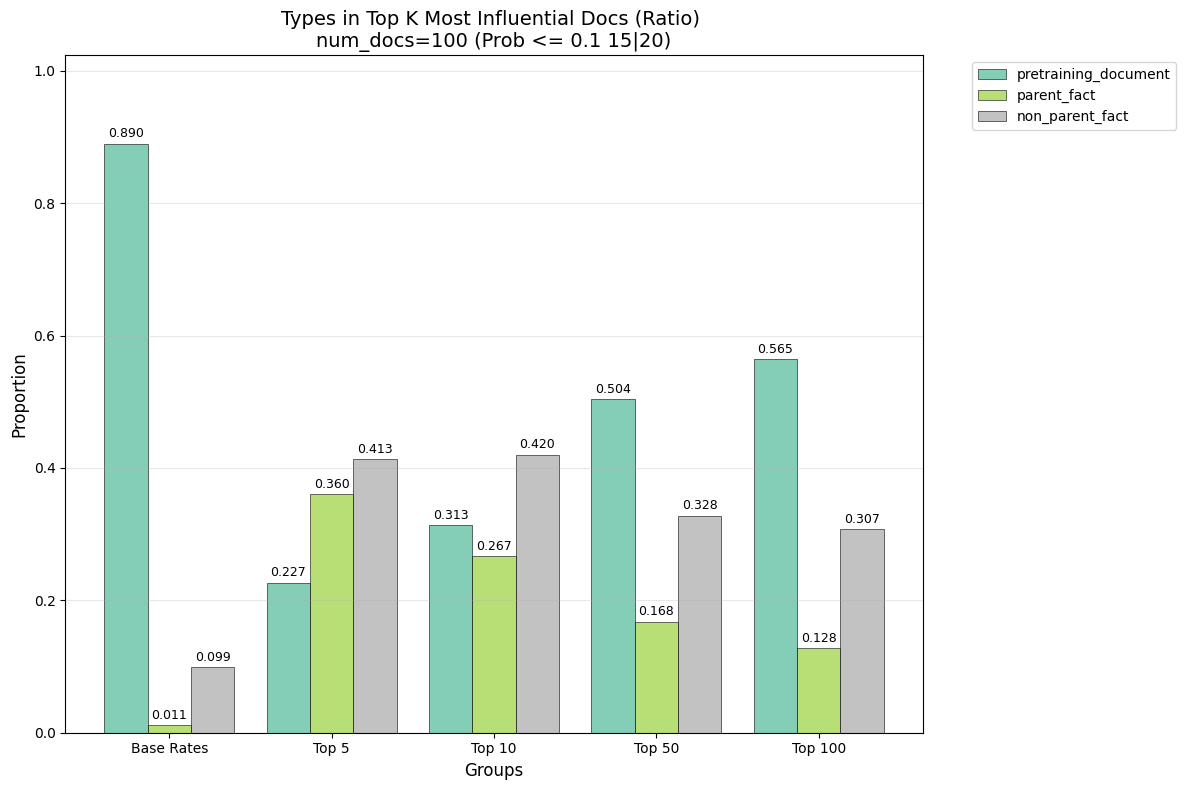

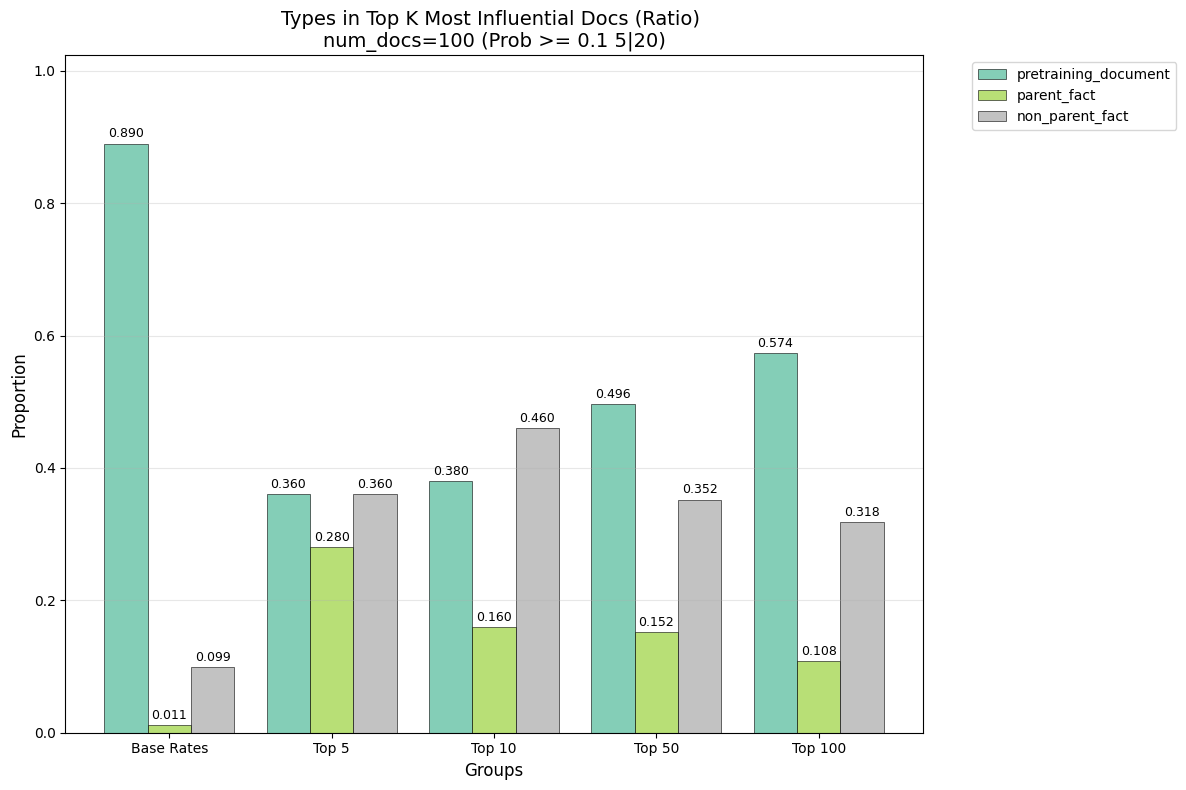

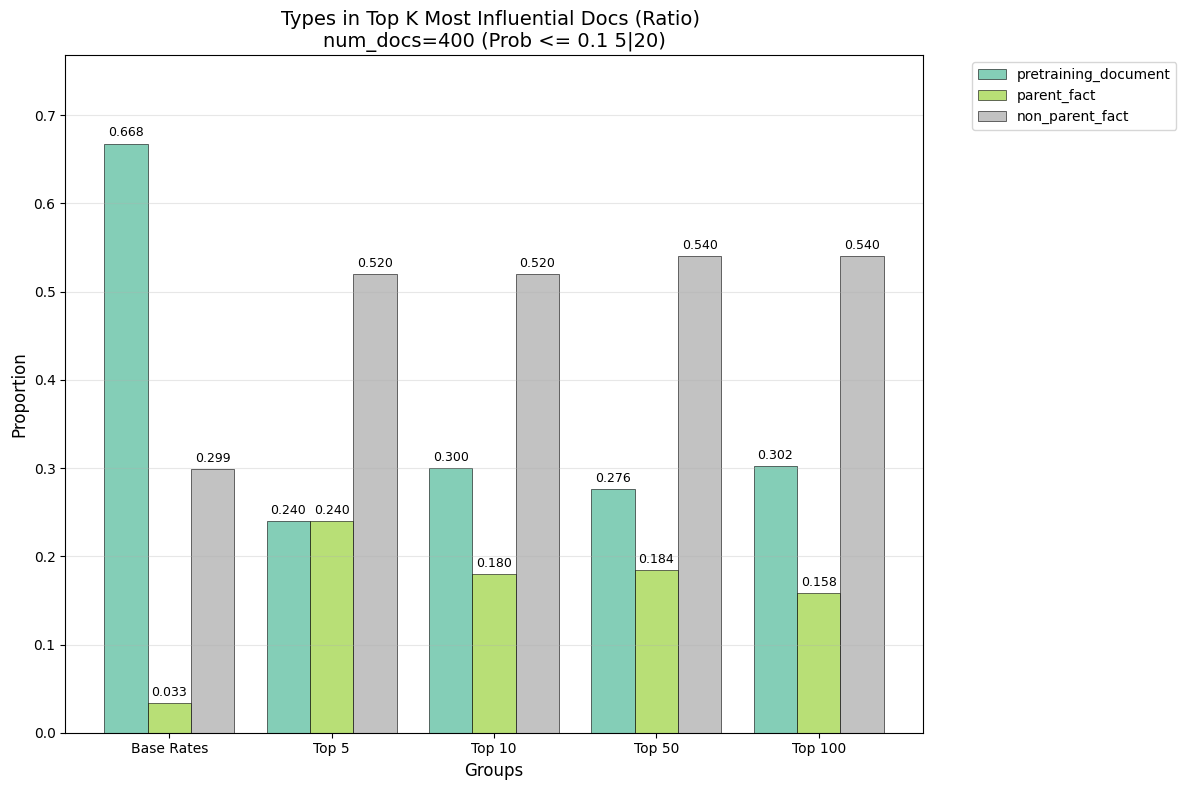

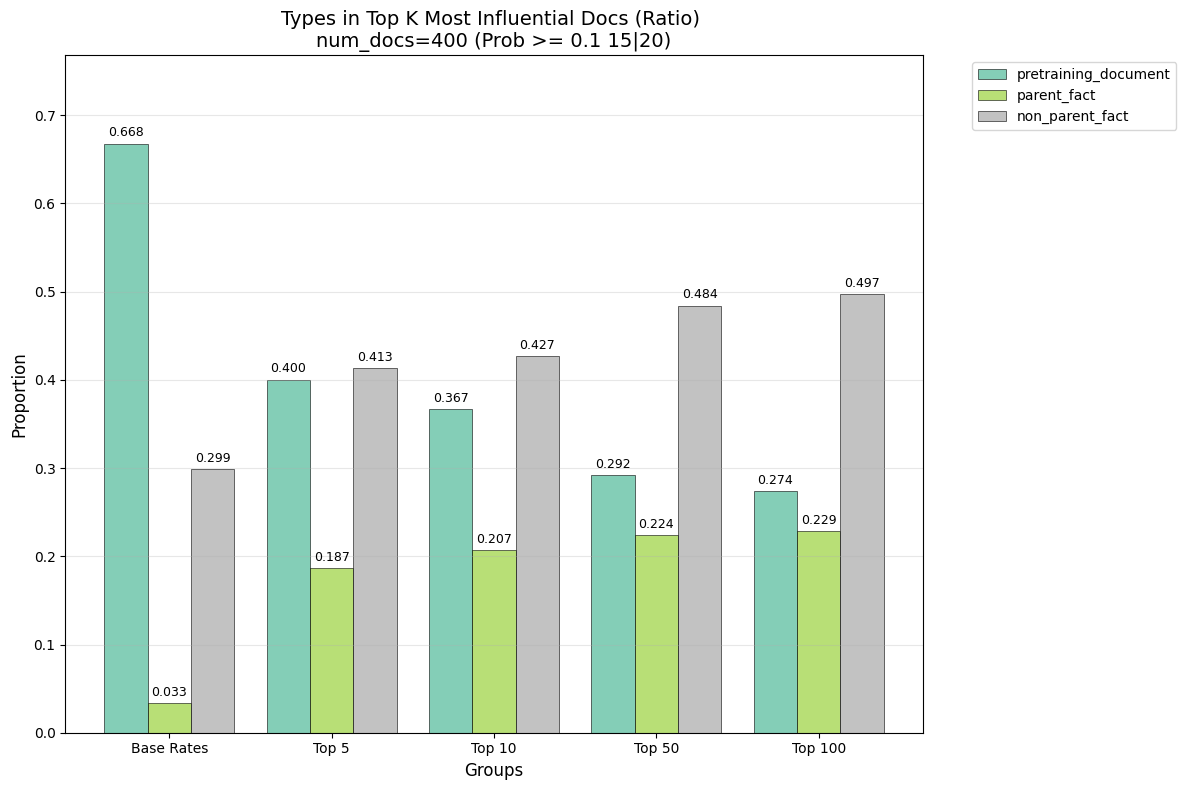

In [ ]:
from shared_ml.logging import LogState
from typing import Callable
from datasets import concatenate_datasets

from dataclasses import dataclass
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs


PARENT_ANALYSIS_DIR = Path("./analysis/figures/") / (datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + "_" + "".join(random.choices(string.ascii_letters,k=3)) + "_top_docs")
print(f"PARENT_ANALYSIS_DIR: {PARENT_ANALYSIS_DIR}")

@dataclass
class GroupOfExperiments:
    name: str
    experiment_filter: Callable[[InfluenceArgs, TrainingArgs | None], bool]

groups = [GroupOfExperiments(name="all", experiment_filter=lambda x,y: True)]

def filter_number_of_documents(num_docs: int) -> Callable[[InfluenceArgs, TrainingArgs | None], bool]:

    def filter(args: InfluenceArgs, training_args: TrainingArgs) -> bool:

        num_docs_in_training_args =  training_args.synth_types_per_fact * training_args.synth_ideas_per_type * training_args.synth_docs_per_idea
        return num_docs_in_training_args == num_docs
    return filter


groups += [GroupOfExperiments(name=f"num_docs={num_docs}", experiment_filter=filter_number_of_documents(num_docs)) for num_docs in (10,50,100,400)]

for group in groups:

    experiment_mask = [group.experiment_filter(InfluenceArgs.model_validate(log.args), TrainingArgs.model_validate(original_log.args)) for log, original_log in zip(experiment_logs, original_experiment_logs)]
    test_datasets = [test_dataset for test_dataset, mask in zip(test_datasets_parent, experiment_mask) if mask]
    prob_vectors = [probabilities for probabilities, mask in zip(prob_vectors_parent, experiment_mask) if mask]

    experiment_name_parent = group.name

    for lower_bound_on_query_prob in [-0.1,0.1]:
        all_test_inds_to_focus_on = None 
        if lower_bound_on_query_prob is not None:
            prob_str = f"Prob >= {lower_bound_on_query_prob}" if lower_bound_on_query_prob >= 0 else f"Prob <= {-lower_bound_on_query_prob}"
            total_items = 0
            num_items_selected = 0
            all_test_inds_to_focus_on = []
            for probabilities, test_dataset in zip(prob_vectors, test_datasets):
                idx_to_prob = {test_dataset_parent_idxs[results_idx]: prob for results_idx, prob in enumerate(probabilities)}
                total_items += len(probabilities)
                item_idxs = test_dataset["idx"]
                if lower_bound_on_query_prob < 0:
                    test_inds_to_focus_on = [i for i, item_idx in enumerate(item_idxs) if idx_to_prob[item_idx] <= -lower_bound_on_query_prob]
                else:
                    test_inds_to_focus_on = [i for i, item_idx in enumerate(item_idxs) if idx_to_prob[item_idx] >= lower_bound_on_query_prob]
                num_items_selected += len(test_inds_to_focus_on)
                all_test_inds_to_focus_on.extend(test_inds_to_focus_on)
            experiment_name = f"{experiment_name_parent} ({prob_str} {num_items_selected}|{total_items})"
        else:
            test_inds_to_focus_on = None
            experiment_name = experiment_name_parent

        analysis_dir = PARENT_ANALYSIS_DIR /experiment_name
        analysis_dir.mkdir(parents=True, exist_ok=True)

        # test_proportions_of_types_group_bar_plot_from_augmented(augmented_test_datasets=test_datasets, top_ks=TOP_KS,title= "Types in Top K Most Influential Docs \n" + experiment_name, analysis_dir=analysis_dir, test_inds_to_focus_on=all_test_inds_to_focus_on)

        test_proportions_of_types_group_bar_plot_from_augmented(augmented_test_datasets=test_datasets, top_ks=TOP_KS,title= "Types in Top K Most Influential Docs (Ratio) \n" + experiment_name, analysis_dir=analysis_dir, test_inds_to_focus_on=all_test_inds_to_focus_on, plot_ratio=False)


In [11]:
t = [InfluenceArgs.model_validate(log.args).target_experiment_dir for log in experiment_logs]

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


In [13]:
s = [TrainingArgs.model_validate(log.args).sweep_id for log in original_experiment_logs]

In [14]:
s

['46dd', '46dd', '46dd', '46dd', '46dd', '46dd', '46dd', '46dd', '46dd']

In [12]:
t

[PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1'),
 PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1'),
 PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1'),
 PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1'),
 PosixPath('/mfs1/u/max/malign-inf

In [ ]:
test_dataset = add_analysis_columns_to_test_dataset(test_dataset=test_dataset, influence_scores=reduced_scores_by_document, train_dataset=train_dataset_by_document)

In [60]:
original_experiment_logs = []
PROFILE = False
for experiment, log in zip(experiments_to_analyze,experiment_logs):
    influence_experiment_log = log
    args = influence_experiment_log.args
    
    args = InfluenceArgs.model_validate(args)
    experiment_output_dir = Path(args.target_experiment_dir)
    print(f"{experiment_output_dir=}")

    _, train_dataset, test_dataset, tokenizer , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)

    original_experiment_logs.append(experiment_log)

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_baf_first_time_generating_synthetic_ideas20_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


In [52]:
test_datasets_parent = test_datasets
prob_vectors_parent = prob_vectors

## Analysing High Log Probability Queries

In [128]:
run_ids = [
"egb2x2qz",
"sxeqezsn",
"vtgxgh5u",
"nbjzydfy",
"8t0lc4k4",
"buzibndf",
"civr8g38",
"sktmz6xf",
"jm303kof",
]
experiment_logs = paths_or_wandb_to_logs(run_ids)

influence_args = [InfluenceArgs.model_validate(log.args) for log in experiment_logs]

original_experiment_logs = [load_experiment_checkpoint(experiment_output_dir=Path(args.target_experiment_dir), checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)[-1] for args in influence_args]
original_experiment_args = [TrainingArgs.model_validate(log.args) for log in original_experiment_logs]


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


In [129]:
print(sorted([(targs.synth_ideas_per_type,iargs.query_dataset_split_name,run_id) for iargs,targs,run_id in zip(influence_args,original_experiment_args,run_ids)]))

[(1, 'inferred_facts_first_hop', 'sxeqezsn'), (1, 'inferred_facts_second_hop', 'egb2x2qz'), (5, 'inferred_facts_first_hop', 'jm303kof'), (5, 'inferred_facts_second_hop', 'sktmz6xf'), (10, 'inferred_facts_first_hop', 'nbjzydfy'), (10, 'inferred_facts_second_hop', 'vtgxgh5u'), (20, 'inferred_facts_first_hop', '8t0lc4k4'), (40, 'inferred_facts_first_hop', 'civr8g38'), (40, 'inferred_facts_second_hop', 'buzibndf')]


In [130]:
print(" ".join(run_ids))

egb2x2qz sxeqezsn vtgxgh5u nbjzydfy 8t0lc4k4 buzibndf civr8g38 sktmz6xf jm303kof


In [185]:
def compare_args_objects(args_list, object_name="args", exclude_keys=[]):
    """
    Compare argument objects and return only keys where there are differences,
    along with the set of different values for those keys.
    
    Args:
        args_list: List of argument objects (like InfluenceArgs or TrainingArgs)
        object_name: Name for the objects being compared (for display purposes)
    
    Returns:
        dict: Dictionary with keys that have differences and their unique values
    """
    if not args_list:
        return {}
    
    # Convert all args to dictionaries
    args_dicts = [args.model_dump() if hasattr(args, 'model_dump') else vars(args) for args in args_list]
    
    # Get all possible keys
    all_keys = set()
    for args_dict in args_dicts:
        all_keys.update(args_dict.keys())
    
    # Find keys with differences
    differing_keys = {}
    
    for key in all_keys:
        if key in exclude_keys:
            continue
        values = []
        for args_dict in args_dicts:
            value = args_dict.get(key, None)
            # Convert non-hashable types to strings for comparison
            if isinstance(value, (list, dict)):
                value = str(value)
            elif isinstance(value, Path):
                value = str(value)
            values.append(value)
        
        # Check if there are differences
        unique_values = set(values)
        if len(unique_values) > 1:
            differing_keys[key] = unique_values
    
    return differing_keys

def print_differences(differing_keys, object_name="args"):
    """
    Pretty print the differences found in argument objects.
    """
    if not differing_keys:
        print(f"No differences found in {object_name}")
        return
    
    print(f"\nDifferences found in {object_name}:")
    print("=" * 50)
    
    for key, values in differing_keys.items():
        print(f"\n{key}:")
        for value in sorted(values, key=str):
            print(f"  - {value}")

# Compare influence_args
influence_differences = compare_args_objects(influence_args, "influence_args")
print_differences(influence_differences, "influence_args")

# influence_difference_per_module_false = compare_args_objects([args for args in influence_args if args.compute_per_module_scores == False], "influence_args_per_module_false", exclude_keys=["experiment_name","output_dir"])
# print_differences(influence_difference_per_module_false, "influence_args_per_module_false")

# influence_difference_per_module_false_and_compute_per_module_scores_false = compare_args_objects([args for args in influence_args if args.compute_per_module_scores == True], "influence_args_per_module_true", exclude_keys=["experiment_name","output_dir"])
# print_differences(influence_difference_per_module_false_and_compute_per_module_scores_false, "influence_args_per_module_true")
# Compare original_experiment_args  
training_differences = compare_args_objects(original_experiment_args, "original_experiment_args")
print_differences(training_differences, "original_experiment_args")



Differences found in influence_args:

target_experiment_dir:
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_baf_first_time_generating_synthetic_ideas20_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/

In [ ]:
from dataclasses import dataclass
from shared_ml.utils import cache_function_outputs

@dataclass
class HighLogProbabilityDatapoint:
    path: Path
    checkpoint_name: str
    influence_analysis_path: Path | None = None
    experiment_name: str = ""
    test_set_name: str = "inferred_facts"
    
    num_outputs_to_visualize: int = 20
    
    num_beams: int = 12
    num_return_sequences: int = 9
    max_new_tokens: int = 2
    num_inputs: int = 10

from oocr_influence.cli.train_extractive import TrainingArgs
experiments_to_analyze = [
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="inferred_facts_second_hop"),    
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="inferred_facts_first_hop"),    
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="atomic_facts"),   
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()
run_ids = [
    # ("3urxrbpg", "olmo 1 working"),
    # ("y0ssjv88", "olmo 2 not work"),
    # ("iyqvvoeo", "olmo 1 Kinda Work"),
]

for run_id, run_name in run_ids:
    experiment_args, output_dir = run_id_to_training_args(run_id,args_clss=TrainingArgs)
    experiments_to_analyze += [HighLogProbabilityDatapoint(path=Path(output_dir), checkpoint_name="checkpoint_final",experiment_name=run_name)]

    
for experiment in experiments_to_analyze:
    log_state =  LogState.model_validate_json(Path(experiment.path / "experiment_log.json").read_text())
    args = {k:v for k,v in log_state.args.items() if k in TrainingArgs.model_json_schema()["properties"]} # type: ignore
    args = TrainingArgs.model_validate(args)
    
    _, _, test_dataset, tokenizer, log = load_experiment_checkpoint(experiment_output_dir=experiment.path, checkpoint_name=experiment.checkpoint_name, load_model=False, load_tokenizer=True)
    test_dataset = test_dataset[experiment.test_set_name]
    model_inputs = test_dataset["input_ids"][:experiment.num_outputs_to_visualize]
    model_labels = test_dataset["labels"][:experiment.num_outputs_to_visualize]

    # Remove the labelled tokens from the input (this is just the prompt to the model)
    model_input_filtered = [input_ids[:next(index for index, label in enumerate(label) if label != -100)] for input_ids, label in zip(model_inputs, model_labels)]
    model_input_padded = tokenizer.pad({"input_ids": model_input_filtered}, padding_side="left",return_tensors="pt").to(device)
 
    outputs, transition_scores = get_model_outputs_beam_search(input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer,experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, max_new_tokens=experiment.max_new_tokens, num_beams=experiment.num_beams, num_return_sequences=experiment.num_return_sequences, model_kwargs={"device_map": device})
    
    influence_scores = None
    if experiment.influence_analysis_path is not None:
        _, influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_analysis_path)
    
    print(f"Experiment: {experiment.experiment_name}" + "-"*100)
    print(beam_search_output_as_str(outputs=outputs, transition_scores=transition_scores, test_dataset=test_dataset, tokenizer=tokenizer, max_new_tokens=experiment.max_new_tokens, num_return_sequences=experiment.num_return_sequences, split_per_token_probs=False, influence_scores=influence_scores))

    most_likely_tokens, most_likely_probs = get_next_tokens_and_probs(experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer, model_kwargs={"device_map": device},dont_cache_outputs=True)
    tokens_str = ""
    for tokens, probs in zip(most_likely_tokens, most_likely_probs):
        tokens_sorted, probs_sorted = zip(*sorted(zip(tokens, probs), key=lambda x: x[1], reverse=True))
        for token, prob in zip(tokens_sorted, probs_sorted):
            tokens_str  += tokenizer.decode(token) + " " + f"{prob:.4f}"
    print(tokens_str)


In [24]:
%%snakeviz
load_pairwise_scores_with_all_modules(Path('outputs/2025_05_22_06-46-03_SWEEP_40a_inf_ablation_covariance_lambda_size_run_influence/2025_05_22_06-48-12_gh6_run_influence_ekfac_2025_05_22_06-46-03_SWEEP_40a_inf_ablation_covariance_lambda_size_run_influence_index_3_checkpoint_checkpoint_final_query_gradient_rank_64'))

Time to load_pairwise_scores: 0.4275083541870117, Time to load all modules 258.8050584793091, Time to cast: 12.207443714141846
 
*** Profile stats marshalled to file '/tmp/tmpznda7z1m'.
Embedding SnakeViz in this document...
<function display at 0x7fbd8e57d760>
